In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
# 1. backtest.py

#!/usr/bin/python
# -*- coding: utf-8 -*-


from __future__ import print_function

import datetime
import pprint
try:
    import Queue as queue
except ImportError:
    import queue
import time

print("Executing backtest.py")
class Backtest(object):
    """
    Enscapsulates the settings and components for carrying out
    an event-driven backtest.
    """
#     print("*****backtest.py: 01: Class Backtest(object)*****")
    def __init__(
        self, csv_dir, symbol_list, initial_capital,
        heartbeat, start_date, data_handler, 
        execution_handler, portfolio, strategy
    ):
        """
        Initialises the backtest.
        Parameters:
        csv_dir - The hard root to the CSV data directory.
        symbol_list - The list of symbol strings.
        intial_capital - The starting capital for the portfolio.
        heartbeat - Backtest "heartbeat" in seconds
        start_date - The start datetime of the strategy.
        data_handler - (Class) Handles the market data feed.
        execution_handler - (Class) Handles the orders/fills for trades.
        portfolio - (Class) Keeps track of portfolio current and prior positions.
        strategy - (Class) Generates signals based on market data.
        """
#         print("*****backtest.py: 1. Backtest.initializing..*****")
        self.csv_dir = csv_dir
        self.symbol_list = symbol_list
        self.initial_capital = initial_capital
        self.heartbeat = heartbeat
        self.start_date = start_date

        self.data_handler_cls = data_handler
        self.execution_handler_cls = execution_handler
        self.portfolio_cls = portfolio
        self.strategy_cls = strategy

        # Added by Brad on 20191006
        # self.plots_cls = plots

        self.events = queue.Queue()
        
        self.signals = 0
        self.orders = 0
        self.fills = 0
        self.num_strats = 1
       
        self._generate_trading_instances()

    def _generate_trading_instances(self):
        # function1: call0 classes of 1)DataHandler, 2)strategy, 3)portfolion, 4)ExecutionHandler
        """
        Generates the trading instance objects from 
        their class types.
        """
#         print("*****backtest.py: 2. Backtest._generate_trading_instances*****")
#         print(
#             "backtest.py: _generate_trading_instances: Creating DataHandler, Strategy, Portfolio and ExecutionHandler"
#         )
        self.data_handler = self.data_handler_cls(self.events, self.csv_dir, self.symbol_list)
        self.strategy = self.strategy_cls(self.data_handler, self.events)
        self.portfolio = self.portfolio_cls(self.data_handler, self.events, self.start_date, 
                                            self.initial_capital)
        self.execution_handler = self.execution_handler_cls(self.events)
    

    def _run_backtest(self): # 
        # function1: update market bars
        # function2: identify the current event, including 1)market, 2)signal, 3)order, 4)
        """
        Executes the backtest.
        """
#         print("*****backtest.py: 3. Backtest._run_backtest*****")
#         print("Running Backtest...")
        i = 0
        while True:
            i += 1
            # print(i)

            # Update the market bars
            if self.data_handler.continue_backtest == True:
                self.data_handler.update_bars()
            else:
                break

            # Handle the events
            while True:
                try:
                    event = self.events.get(False)
                except queue.Empty:
                    break
                else:
                    if event is not None:
                        if event.type == 'MARKET':
                            self.strategy.calculate_signals(event)
                            self.portfolio.update_timeindex(event)

                        elif event.type == 'SIGNAL':
                            self.signals += 1                            
                            self.portfolio.update_signal(event)

                        elif event.type == 'ORDER':
                            self.orders += 1
                            self.execution_handler.execute_order(event)

                        elif event.type == 'FILL':
                            self.fills += 1
                            self.portfolio.update_fill(event)

            time.sleep(self.heartbeat)

	# OG version
    # def _output_performance(self):
    #     """
    #     Outputs the strategy performance from the backtest.
    #     """
    #     self.portfolio.create_equity_curve_dataframe()
        
    #     print("Creating summary stats...")
    #     stats = self.portfolio.output_summary_stats()
        
    #     print("Creating equity curve...")
    #     print(self.portfolio.equity_curve.tail(10))
    #     pprint.pprint(stats)

    #     print("Signals: %s" % self.signals)
    #     print("Orders: %s" % self.orders)
    #     print("Fills: %s" % self.fills)


    def _output_performance(self):
        """
        Outputs the strategy performance from the backtest.
        """
        self.portfolio.create_equity_curve_dataframe()
#         print("*****backtest.py: 4. Backtest._output_performance*****")
        print("Creating summary stats...")
        stats = self.portfolio.output_summary_stats()
        
        print("Creating equity curve...")
        print(self.portfolio.equity_curve.tail(10))
        pprint.pprint(stats)

        print("Signals: %s" % self.signals)
        print("Orders: %s" % self.orders)
        print("Fills: %s" % self.fills)

    def simulate_trading(self):
        # function 1: call 1)_run _backtest, 2__output_formance
        """
        Simulates the backtest and outputs portfolio performance.
        """
#         print("*****backtest.py: 5. Backtest.simulate_trading*****")
        self._run_backtest()
        self._output_performance()

Executing backtest.py


In [3]:
# 2. event.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

print("Executing event.py")
class Event(object):
    """
    Event is base class providing an interface for all subsequent 
    (inherited) events, that will trigger further events in the 
    trading infrastructure.   
    """
#     print("*****event.py: 01 Class. Event(object)*****")
    pass


class MarketEvent(Event):
    """
    Handles the event of receiving a new market update with 
    corresponding bars.
    """
#     print("*****event.py: 02 Class. MarketEvent(Event)*****")
    def __init__(self):
        """
        Initialises the MarketEvent.
        """
#         print("*****event.py: 1. initializing..*****")
        self.type = 'MARKET'


class SignalEvent(Event):
    """
    Handles the event of sending a Signal from a Strategy object.
    This is received by a Portfolio object and acted upon.
    """
    print("*****event.py: 03 Class: SignalEvent(Event)*****")
    def __init__(self, strategy_id, symbol, datetime, signal_type, strength):
        """
        Initialises the SignalEvent.
        Parameters:
        strategy_id - The unique ID of the strategy sending the signal.
        symbol - The ticker symbol, e.g. 'GOOG'.
        datetime - The timestamp at which the signal was generated.
        signal_type - 'LONG' or 'SHORT'.
        strength - An adjustment factor "suggestion" used to scale 
            quantity at the portfolio level. Useful for pairs strategies.
        """
#         print("*****event.py: 1. SignalEvent.initializing..*****")
        self.strategy_id = strategy_id
        self.type = 'SIGNAL'
        self.symbol = symbol
        self.datetime = datetime
        self.signal_type = signal_type
        self.strength = strength


class OrderEvent(Event):
    """
    Handles the event of sending an Order to an execution system.
    The order contains a symbol (e.g. GOOG), a type (market or limit),
    quantity and a direction.
    """
    print("*****event.py: 04 Class: OrderEvent(Event)*****")
    def __init__(self, symbol, order_type, quantity, direction):
        """
        Initialises the order type, setting whether it is
        a Market order ('MKT') or Limit order ('LMT'), has
        a quantity (integral) and its direction ('BUY' or
        'SELL').
        TODO: Must handle error checking here to obtain 
        rational orders (i.e. no negative quantities etc).
        Parameters:
        symbol - The instrument to trade.
        order_type - 'MKT' or 'LMT' for Market or Limit.
        quantity - Non-negative integer for quantity.
        direction - 'BUY' or 'SELL' for long or short.
        """
#         print("*****event.py: 1. OrderEvent.initializing..*****")
        self.type = 'ORDER'
        self.symbol = symbol
        self.order_type = order_type
        self.quantity = quantity
        self.direction = direction

    def print_order(self):
        """
        Outputs the values within the Order.
        """
#         print("*****event.py: 2. OrderEvent.print_order*****")
        print(
            "Order: Symbol=%s, Type=%s, Quantity=%s, Direction=%s" % 
            (self.symbol, self.order_type, self.quantity, self.direction)
        )


class FillEvent(Event):
    """
    Encapsulates the notion of a Filled Order, as returned
    from a brokerage. Stores the quantity of an instrument
    actually filled and at what price. In addition, stores
    the commission of the trade from the brokerage.
    
    TODO: Currently does not support filling positions at
    different prices. This will be simulated by averaging
    the cost.
    """
#     print("*****event.py: 05 Class: FillEvent(Event)*****")
    def __init__(self, timeindex, symbol, exchange, quantity, 
                 direction, fill_cost, commission=None):
        """
        Initialises the FillEvent object. Sets the symbol, exchange,
        quantity, direction, cost of fill and an optional 
        commission.
        If commission is not provided, the Fill object will
        calculate it based on the trade size and Interactive
        Brokers fees.
        Parameters:
        timeindex - The bar-resolution when the order was filled.
        symbol - The instrument which was filled.
        exchange - The exchange where the order was filled.
        quantity - The filled quantity.
        direction - The direction of fill ('BUY' or 'SELL')
        fill_cost - The holdings value in dollars.
        commission - An optional commission sent from IB.
        """
#         print("*****event.py: 1. FillEvent.initializing..*****")
        self.type = 'FILL'
        self.timeindex = timeindex
        self.symbol = symbol
        self.exchange = exchange
        self.quantity = quantity
        self.direction = direction
        self.fill_cost = fill_cost

        # Calculate commission
        if commission is None:
            self.commission = self.calculate_ib_commission()
        else:
            self.commission = commission

    def calculate_ib_commission(self):
        """
        Calculates the fees of trading based on an Interactive
        Brokers fee structure for API, in USD.
        This does not include exchange or ECN fees.
        Based on "US API Directed Orders":
        https://www.interactivebrokers.com/en/index.php?f=commission&p=stocks2
        """
#         print("*****event.py: 2. FillEvent.calculate_ib_commission*****")
#         full_cost = 1.3
#         if self.quantity <= 500:
#             full_cost = max(1.3, 0.013 * self.quantity)
#         else: # Greater than 500
#             full_cost = max(1.3, 0.008 * self.quantity)
        full_cost = commissions
        return full_cost

Executing event.py
*****event.py: 03 Class: SignalEvent(Event)*****
*****event.py: 04 Class: OrderEvent(Event)*****


In [4]:
# 3. data.py
#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

from abc import ABCMeta, abstractmethod
import datetime
import os, os.path

import numpy as np
import pandas as pd

# from event import MarketEvent

print("Executing data.py")
class DataHandler(object):
    """
    DataHandler is an abstract base class providing an interface for
    all subsequent (inherited) data handlers (both live and historic).
    The goal of a (derived) DataHandler object is to output a generated
    set of bars (OHLCVI) for each symbol requested. 
    This will replicate how a live strategy would function as current
    market data would be sent "down the pipe". Thus a historic and live
    system will be treated identically by the rest of the backtesting suite.
    """
#     print("*****data.py: 01 Class: Datahandler(object) ran, an abstract base class*****")
    __metaclass__ = ABCMeta

    @abstractmethod
    def get_latest_bar(self, symbol):
#         print("*****data.py: 1. DataHandler.get_latest_bar*****")
        """
        Returns the last bar updated.
        """
        raise NotImplementedError("Should implement get_latest_bar()")

    @abstractmethod
    def get_latest_bars(self, symbol, N=1):
#         print("*****data.py: 2. DataHandler.get_latest_bars*****")
        """
        Returns the last N bars updated.
        """
        raise NotImplementedError("Should implement get_latest_bars()")

    @abstractmethod
    def get_latest_bar_datetime(self, symbol):
#         print("*****data.py: 3. DataHandler.get_latest_bar_datetime*****")
        """
        Returns a Python datetime object for the last bar.
        """
        raise NotImplementedError("Should implement get_latest_bar_datetime()")

    @abstractmethod
    def get_latest_bar_value(self, symbol, val_type):
#         print("*****data.py: 4. DataHandler.get_latest_bar_value*****")
        """
        Returns one of the Open, High, Low, Close, Volume or OI
        from the last bar.
        """
        raise NotImplementedError("Should implement get_latest_bar_value()")

    @abstractmethod
    def get_latest_bars_values(self, symbol, val_type, N=1):
#         print("*****data.py: 5. DataHandler.get_latest_bars_values*****")
        """
        Returns the last N bar values from the 
        latest_symbol list, or N-k if less available.
        """
        raise NotImplementedError("Should implement get_latest_bars_values()")

    @abstractmethod
    def update_bars(self):
#         print("*****data.py: 6. DataHandler.update_bars*****")
        """
        Pushes the latest bars to the bars_queue for each symbol
        in a tuple OHLCVI format: (datetime, open, high, low, 
        close, volume, open interest).
        """
        raise NotImplementedError("Should implement update_bars()")


class HistoricCSVDataHandler(DataHandler):
    """
    HistoricCSVDataHandler is designed to read CSV files for
    each requested symbol from disk and provide an interface
    to obtain the "latest" bar in a manner identical to a live
    trading interface. 
    """
    print("*****data.py: 02 Class: HistoricCSVDataHandler(DataHandler)*****")
    def __init__(self, events, csv_dir, symbol_list):
        
#         print("*****data.py: 1. HistoricCSVDataHandler.initializing..")
        """
        Initialises the historic data handler by requesting
        the location of the CSV files and a list of symbols.
        It will be assumed that all files are of the form
        'symbol.csv', where symbol is a string in the list.
        Parameters:
        events - The Event Queue.
        csv_dir - Absolute directory path to the CSV files.
        symbol_list - A list of symbol strings.
        """
        self.events = events
        self.csv_dir = csv_dir
        self.symbol_list = symbol_list

        self.symbol_data = {}
        self.latest_symbol_data = {}
        self.continue_backtest = True       
        self.bar_index = 0
        self.backtest_start_date = backtest_start_date

        self._open_convert_csv_files()

    def _open_convert_csv_files(self):
        """
        Opens the CSV files from the data directory, converting
        them into pandas DataFrames within a symbol dictionary.
        For this handler it will be assumed that the data is
        taken from Yahoo. Thus its format will be respected.
        """
#         print("*****data.py: 2. HistoricCSVDataHandler._open_convert_csv_files")
        comb_index = None
        
        for s in self.symbol_list:
            # Load the CSV file with no header information, indexed on date
            self.symbol_data[s] = pd.io.parsers.read_csv(
                os.path.join(self.csv_dir, '%s.csv' % s),
                header=0, index_col=0, parse_dates=True,
                names=data_cols
            )
            
            self.symbol_data[s].reset_index(inplace = True)
            self.symbol_data[s].set_index(date_col, inplace=True)
            
            
            # Brad's revision resetting the start date of the timestamp: 
#             self.symbol_data[s] = self.symbol_data[s][self.symbol_data[date_col]>=backtest_start_date]
            self.symbol_data[s] = self.symbol_data[s][backtest_start_date:]
            
            # ).sort_values('date')
            # print("symbol_data",self.symbol_data[s])#######################
            # Combine the index to pad forward values
            if comb_index is None:
                comb_index = self.symbol_data[s].index
            else:
                comb_index.union(self.symbol_data[s].index)

            # Set the latest symbol_data to None
            self.latest_symbol_data[s] = []

        # Reindex the dataframes
        for s in self.symbol_list:
            self.symbol_data[s] = self.symbol_data[s].\
                reindex(index=comb_index, method='pad').iterrows()
                


    def _get_new_bar(self, symbol):
        """
        Returns the latest bar from the data feed.
        """
#         print("*****data.py: 3. HistoricCSVDataHandler._get_new_bar")
        for b in self.symbol_data[symbol]:
            yield b

    def get_latest_bar(self, symbol):
        """
        Returns the last bar from the latest_symbol list.
        """
#         print("*****data.py: 4. HistoricCSVDataHandler.get_latest_bar")
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return bars_list[-1]

    def get_latest_bars(self, symbol, N=1):
        """
        Returns the last N bars from the latest_symbol list,
        or N-k if less available.
        """
#         print("*****data.py: 5. HistoricCSVDataHandler.get_latest_bars")

        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return bars_list[-N:]

    def get_latest_bar_datetime(self, symbol):
        """
        Returns a Python datetime object for the last bar.
        """
#         print("*****data.py: 6. HistoricCSVDataHandler.get_latest_bar_datetime")
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return bars_list[-1][0]

    def get_latest_bar_value(self, symbol, val_type):
        """
        Returns one of the Open, High, Low, Close, Volume or OI
        values from the pandas Bar series object.
        """
#         print("*****data.py: 7. HistoricCSVDataHandler.get_latest_bar_value")
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return getattr(bars_list[-1][1], val_type)

    def get_latest_bars_values(self, symbol, val_type, N=1):
        """
        Returns the last N bar values from the 
        latest_symbol list, or N-k if less available.
        """
#         print("*****data.py: 8. HistoricCSVDataHandler.get_latest_bars_values")
        try:
            bars_list = self.get_latest_bars(symbol, N)
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return np.array([getattr(b[1], val_type) for b in bars_list])

    def update_bars(self):
        """
        Pushes the latest bar to the latest_symbol_data structure
        for all symbols in the symbol list.
        """
#         print("*****data.py: 9. HistoricCSVDataHandler.update_bars")
        for s in self.symbol_list:
            try:
                bar = next(self._get_new_bar(s))
            except StopIteration:
                self.continue_backtest = False
            else:
                if bar is not None:
                    self.latest_symbol_data[s].append(bar)
        self.events.put(MarketEvent())

Executing data.py
*****data.py: 02 Class: HistoricCSVDataHandler(DataHandler)*****


In [5]:
# 4. execution.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

from abc import ABCMeta, abstractmethod
import datetime
try:
    import Queue as queue
except ImportError:
    import queue

# from event import FillEvent, OrderEvent

print("Executing execution.py")
class ExecutionHandler(object):
    """
    The ExecutionHandler abstract class handles the interaction
    between a set of order objects generated by a Portfolio and
    the ultimate set of Fill objects that actually occur in the
    market. 
    The handlers can be used to subclass simulated brokerages
    or live brokerages, with identical interfaces. This allows
    strategies to be backtested in a very similar manner to the
    live trading engine.
    """
#     print ("*****execution.py: 01. Class: ExecutionHandler(object): abstract class*****")
    __metaclass__ = ABCMeta

    @abstractmethod
    def execute_order(self, event):
#         print("*****execution.py: 1. ExecutionHandler.execute_order*****")
        """
        Takes an Order event and executes it, producing
        a Fill event that gets placed onto the Events queue.
        Parameters:
        event - Contains an Event object with order information.
        """
        raise NotImplementedError("Should implement execute_order()")


class SimulatedExecutionHandler(ExecutionHandler):
    
    """
    The simulated execution handler simply converts all order
    objects into their equivalent fill objects automatically
    without latency, slippage or fill-ratio issues.
    This allows a straightforward "first go" test of any strategy,
    before implementation with a more sophisticated execution
    handler.
    """
#     print ("*****execution.py: 02. Class: SimulatedExecutionHandler(ExecutionHandler)*****")
    def __init__(self, events):
        """
        Initialises the handler, setting the event queues
        up internally.
        Parameters:
        events - The Queue of Event objects.
        """
#         print("*****execution.py: 1. SimulatedExecutionHandler.initializing..*****")
        self.events = events

    def execute_order(self, event):
        """
        Simply converts Order objects into Fill objects naively,
        i.e. without any latency, slippage or fill ratio problems.
        Parameters:
        event - Contains an Event object with order information.
        """
#         print("*****execution.py: 2. SimulatedExecutionHandler.execute_order*****")
        if event.type == 'ORDER':
            fill_event = FillEvent(
                datetime.datetime.utcnow(), event.symbol,
                'ARCA', event.quantity, event.direction, None
            )
            self.events.put(fill_event)

Executing execution.py


In [6]:
# 5. strategy.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

from abc import ABCMeta, abstractmethod
import datetime
try:
    import Queue as queue
except ImportError:
    import queue

import numpy as np
import pandas as pd

# from event import SignalEvent

print("Executing strategy.py")
class Strategy(object):
#     print("*****strategy.py: 01. Class: Strategy(object): abstract class*****")
    """
    Strategy is an abstract base class providing an interface for
    all subsequent (inherited) strategy handling objects.
    The goal of a (derived) Strategy object is to generate Signal
    objects for particular symbols based on the inputs of Bars 
    (OHLCV) generated by a DataHandler object.
    This is designed to work both with historic and live data as
    the Strategy object is agnostic to where the data came from,
    since it obtains the bar tuples from a queue object.
    """

    __metaclass__ = ABCMeta

    @abstractmethod
    def calculate_signals(self):
#         print("*****strategy.py: 1. Strategy(object).calculate_signals*****")
        """
        Provides the mechanisms to calculate the list of signals.
        """
        raise NotImplementedError("Should implement calculate_signals()")

Executing strategy.py


In [7]:
# 6. portfolio.py

#!/usr/bin/python
# -*- coding: utf-8 -*-


from __future__ import print_function

import datetime
from math import floor
try:
    import Queue as queue
except ImportError:
    import queue

import numpy as np
import pandas as pd

# from event import FillEvent, OrderEvent
# from performance import create_sharpe_ratio, create_drawdowns


print("Executing portfolio.py")
class Portfolio(object):
    
#     print("*****portfolio.py: 01. Portfolio(object)*****")
    """
    The Portfolio class handles the positions and market
    value of all instruments at a resolution of a "bar",
    i.e. secondly, minutely, 5-min, 30-min, 60 min or EOD.
    The positions DataFrame stores a time-index of the 
    quantity of positions held. 
    The holdings DataFrame stores the cash and total market
    holdings value of each symbol for a particular 
    time-index, as well as the percentage change in 
    portfolio total across bars.
    """

    def __init__(self, bars, events, start_date, initial_capital=100000.0):
#         print("*****portfolio.py: 1. Portfolio.initializing...*****")
        """
        Initialises the portfolio with bars and an event queue. 
        Also includes a starting datetime index and initial capital 
        (USD unless otherwise stated).
        Parameters:
        bars - The DataHandler object with current market data.
        events - The Event Queue object.
        start_date - The start date (bar) of the portfolio.
        initial_capital - The starting capital in USD.
        """
        self.bars = bars
        self.events = events
        self.symbol_list = self.bars.symbol_list
        self.start_date = start_date
        self.initial_capital = initial_capital
        
        self.all_positions = self.construct_all_positions()
        self.current_positions = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        self.all_holdings = self.construct_all_holdings()
        self.current_holdings = self.construct_current_holdings()
        
        # Brad's add on 20191117
#         fill.direction = "None"
#         self.fill_cost = self.update_holdings_from_fill(self, fill)
        
        # =============brad's added on 20191117:===============
        self.len_symbol_list = len(symbol_list)
        
        
#         print("Number of assets in the portfolio： ",self.len_symbol_list)
        print("Position Value for each asset: ", self.initial_capital/self.len_symbol_list)

        
    def construct_all_positions(self):
#         print("*****portfolio.py: 2. Portfolio.construct_all_positions*****")
        """
        Constructs the positions list using the start_date
        to determine when the time index will begin.
        """
        d = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        d['datetime'] = self.start_date
        return [d]

    def construct_all_holdings(self):
#         print("*****portfolio.py: 3. Portfolio.construct_all_holdings*****")
        """
        Constructs the holdings list using the start_date
        to determine when the time index will begin.
        """
        d = dict( (k,v) for k, v in [(s, 0.0) for s in self.symbol_list] )
        d['datetime'] = self.start_date
        d['cash'] = self.initial_capital
        d['commission'] = 0
        d['total'] = self.initial_capital
        return [d]

    def construct_current_holdings(self):
#         print("*****portfolio.py: 4. Portfolio.construct_current_holdings*****")
        """
        This constructs the dictionary which will hold the instantaneous
        value of the portfolio across all symbols.
        """
        d = dict( (k,v) for k, v in [(s, 0.0) for s in self.symbol_list] )
        d['cash'] = self.initial_capital
        d['commission'] = 0
        d['total'] = self.initial_capital
        return d

    def update_timeindex(self, event):
#         print("*****portfolio.py: 5. Portfolio.update_timeindex*****")
        """
        Adds a new record to the positions matrix for the current 
        market data bar. This reflects the PREVIOUS bar, i.e. all
        current market data at this stage is known (OHLCV).
        Makes use of a MarketEvent from the events queue.
        """
        ##print("symbol_list",self.symbol_list)
        latest_datetime = self.bars.get_latest_bar_datetime(self.symbol_list[0])
        #######################
        
        
#         print("latest_datetime:", latest_datetime)
        # Update positions
        # ================
        dp = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        dp['datetime'] = latest_datetime

        for s in self.symbol_list:
            dp[s] = self.current_positions[s]

        # Append the current positions
        self.all_positions.append(dp)

        # Update holdings
        # ===============
        dh = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        dh['datetime'] = latest_datetime
        dh['cash'] = self.current_holdings['cash']
        dh['commission'] = self.current_holdings['commission']
        dh['total'] = self.current_holdings['cash']

        for s in self.symbol_list:
            # Approximation to the real value
            market_value = self.current_positions[s] * \
                self.bars.get_latest_bar_value(s, "Open")
            dh[s] = market_value
            dh['total'] += market_value

        # Append the current holdings
        self.all_holdings.append(dh)

    # ======================
    # FILL/POSITION HANDLING
    # ======================

    def update_positions_from_fill(self, fill):
#         print("*****portfolio.py: 6. Portfolio.update_positions_from_fill*****")
        """
        Takes a Fill object and updates the position matrix to
        reflect the new position.
        Parameters:
        fill - The Fill object to update the positions with.
        """
        # Check whether the fill is a buy or sell
        fill_dir = 0
        if fill.direction == 'BUY':
            fill_dir = 1
        if fill.direction == 'SELL':
            fill_dir = -1

        # Update positions list with new quantities
        self.current_positions[fill.symbol] += fill_dir*fill.quantity

    def update_holdings_from_fill(self, fill):
#         print("*****portfolio.py: 7. Portfolio.update_holdings_from_fill*****")
        """
        Takes a Fill object and updates the holdings matrix to
        reflect the holdings value.
        Parameters:
        fill - The Fill object to update the holdings with.
        """
        # Check whether the fill is a buy or sell
        fill_dir = 0
        if fill.direction == 'BUY':
            fill_dir = 1
        if fill.direction == 'SELL':
            fill_dir = -1

        # Update holdings list with new quantities
        fill_cost = self.bars.get_latest_bar_value(
            fill.symbol, price_col
        )
        cost = fill_dir * fill_cost * fill.quantity
        self.current_holdings[fill.symbol] += cost
        self.current_holdings['commission'] += fill.commission
        self.current_holdings['cash'] -= (cost + fill.commission)
        self.current_holdings['total'] -= (cost + fill.commission)
        # Brad's add on 20191117
        return fill_cost

    def update_fill(self, event):
#         print("*****portfolio.py: 8. Portfolio.update_fill*****")
        """
        Updates the portfolio current positions and holdings 
        from a FillEvent.
        """
        if event.type == 'FILL':
            self.update_positions_from_fill(event)
            self.update_holdings_from_fill(event)

    def generate_naive_order(self, signal):
#         print("*****portfolio.py: 9. Portfolio.generate_naive_order*****")
        """
        Simply files an Order object as a constant quantity
        sizing of the signal object, without risk management or
        position sizing considerations.
        Parameters:
        signal - The tuple containing Signal information.
        """
        order = None

        symbol = signal.symbol
        direction = signal.signal_type
        strength = signal.strength
        # ================ Brad's change on 20191117 =================
#         mkt_quantity = qty
        symbol_value = self.bars.get_latest_bar_value(symbol, price_col)
        mkt_quantity = int(self.initial_capital/self.len_symbol_list/symbol_value)
        print("Asset: ", symbol, "symbol_value: ",symbol_value,  "mkt_quantity: ", mkt_quantity)
        cur_quantity = self.current_positions[symbol]
        order_type = 'MKT'

        
        if direction == 'LONG' and cur_quantity == 0:
            order = OrderEvent(symbol, order_type, mkt_quantity, 'BUY')
        if direction == 'SHORT' and cur_quantity == 0:
            order = OrderEvent(symbol, order_type, mkt_quantity, 'SELL')   
    
#         if direction == 'LONG' and cur_quantity < 0:
#             order = OrderEvent(symbol, order_type, 2*mkt_quantity, 'BUY')
#         if dirction == 'SHORT' and cur_quantity > 0:
#             order = OrderEvent(symbol, order_type, 2*mkt_quantity, 'SELL')
    
        if direction == 'EXIT' and cur_quantity > 0:
            order = OrderEvent(symbol, order_type, abs(cur_quantity), 'SELL')
        if direction == 'EXIT' and cur_quantity < 0:
            order = OrderEvent(symbol, order_type, abs(cur_quantity), 'BUY')
        return order

    def update_signal(self, event):
#         print("*****portfolio.py: 10. Portfolio.update_signal*****")
        """
        Acts on a SignalEvent to generate new orders 
        based on the portfolio logic.
        """
        if event.type == 'SIGNAL':
            order_event = self.generate_naive_order(event)
            self.events.put(order_event)

    # ========================
    # POST-BACKTEST STATISTICS
    # ========================

    def create_equity_curve_dataframe(self):
#         print("*****portfolio.py: 11. Portfolio.create_equity_curve_dataframe*****")
        """
        Creates a pandas DataFrame from the all_holdings
        list of dictionaries.
        """
        curve = pd.DataFrame(self.all_holdings)
        curve.set_index('datetime', inplace=True)
        curve['returns'] = curve['total'].pct_change()
        curve['equity_curve'] = (1.0+curve['returns']).cumprod()
        self.equity_curve = curve

    def output_summary_stats(self):
#         print("*****portfolio.py: 12. Portfolio.output_summary_stats*****")
        """
        Creates a list of summary statistics for the portfolio.
        """
        total_return = self.equity_curve['equity_curve'][-1]
        returns = self.equity_curve['returns']
        pnl = self.equity_curve['equity_curve']

        sharpe_ratio = create_sharpe_ratio(returns, periods=252*60*6.5)
        drawdown, max_dd, dd_duration = create_drawdowns(pnl)
        self.equity_curve['drawdown'] = drawdown

        stats = [("Total Return", "%0.2f%%" % ((total_return - 1.0) * 100.0)),
                 ("Sharpe Ratio", "%0.2f" % sharpe_ratio),
                 ("Max Drawdown", "%0.2f%%" % (max_dd * 100.0)),
                 ("Drawdown Duration", "%d" % dd_duration)]

        self.equity_curve.to_csv(ticker+"_performance"+".csv")
#         return self.equity_curve
        print(stats)


class Visualization(Portfolio):
    def output_summary_stats(self):
#         print("*****portfolio.py: 12. Portfolio.output_summary_stats*****")
        """
        Creates a list of summary statistics for the portfolio.
        """
        total_return = self.equity_curve['equity_curve'][-1]
        returns = self.equity_curve['returns']
        pnl = self.equity_curve['equity_curve']

        sharpe_ratio = create_sharpe_ratio(returns, periods=252*60*6.5)
        drawdown, max_dd, dd_duration = create_drawdowns(pnl)
        self.equity_curve['drawdown'] = drawdown
        self.equity_curve['drawdown'].plot()

#         stats = [("Total Return", "%0.2f%%" % ((total_return - 1.0) * 100.0)),
#                  ("Sharpe Ratio", "%0.2f" % sharpe_ratio),
#                  ("Max Drawdown", "%0.2f%%" % (max_dd * 100.0)),
#                  ("Drawdown Duration", "%d" % dd_duration)]

#     def __init__(self, bars, events, start_date, initial_capital=100000.0):
#         self.stats_to_plot = super().output_summary_stats()

#     def plot_cash(self):
#         self.stats_to_plot['cash'].plot()

#     # Added by Brad on 20191007:
#     def draw_summary_plots(self):
#         print("*****portfolio.py: 13. Portfolio.draw_summary_plots*****")
#         self.equity_curve['equity_curve'].plot(figsize = (18,6))

Executing portfolio.py


In [8]:
# 7. performance.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

import numpy as np
import pandas as pd

print("Executing performance.py")
def create_sharpe_ratio(returns, periods=252):
    print("*****performance.py: 1. create_sharpe_ratio*****")
    """
    Create the Sharpe ratio for the strategy, based on a 
    benchmark of zero (i.e. no risk-free rate information).
    Parameters:
    returns - A pandas Series representing period percentage returns.
    periods - Daily (252), Hourly (252*6.5), Minutely(252*6.5*60) etc.
    """
    return np.sqrt(periods) * (np.mean(returns)) / np.std(returns)


def create_drawdowns(pnl):
    print("*****performance.py: 2. create_drawdowns*****")
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.
    Parameters:
    pnl - A pandas Series representing period percentage returns.
    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """

    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    hwm = [0]

    # Create the drawdown and duration series
    idx = pnl.index
    drawdown = pd.Series(index = idx)
    duration = pd.Series(index = idx)

    # Loop over the index range
    for t in range(1, len(idx)):
        hwm.append(max(hwm[t-1], pnl[t]))
        drawdown[t]= (hwm[t]-pnl[t])
        duration[t]= (0 if drawdown[t] == 0 else duration[t-1]+1)
    return drawdown, drawdown.max(), duration.max()

Executing performance.py


In [9]:
# mac.py
print("Executing mac.py")
class MovingAverageCrossStrategy(Strategy):
    print("*****mac.py: 01. Class: MovingAverageCrossStrategy(Strategy)*****")
    """
    Carries out a basic Moving Average Crossover strategy with a
    short/long simple weighted moving average. Default short/long
    windows are 12/26 periods respectively.
    """

    def __init__(self, bars, events, short_window=12, long_window=26):
        print("*****mac.py: 1. MovingAverageCrossStrategy.initializing..*****")
        """
        Initialises the buy and hold strategy.

        Parameters:
        bars - The DataHandler object that provides bar information
        events - The Event Queue object.
        short_window - The short moving average lookback.
        long_window - The long moving average lookback.
        """
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()

    def _calculate_initial_bought(self):
        print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_bought*****")
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
        print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold

    def calculate_signals(self, event):
        print("*****mac.py: 3. MovingAverageCrossStrategy.calculate_signals*****")
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.    

        Parameters
        event - A MarketEvent object. 
        """
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)

                if bars is not None and bars != []:
                    short_sma = np.mean(bars[-self.short_window:])
                    long_sma = np.mean(bars[-self.long_window:])

                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if short_sma > long_sma and self.bought[symbol] == "OUT":
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif short_sma < long_sma and self.bought[symbol] == "LONG":
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'

Executing mac.py
*****mac.py: 01. Class: MovingAverageCrossStrategy(Strategy)*****


In [10]:
class MovingAverageConvergenceDivergence(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
        # Set to True if a symbol is in the market
        self.sold = self._calculate_initial_sold()

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
        print("*****mac.py: 2. MovingAverageConvergenceDivergence._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold
    

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
#                 print(bars)
                if bars is not None and bars != []:
                    exp1 = pd.Series(bars).ewm(span=12, adjust=False).mean()
                    exp2 = pd.Series(bars).ewm(span=26, adjust=False).mean()
                    macd = exp1 - exp2
                    exp3 = macd.ewm(span=9, adjust=False).mean()
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if macd.iloc[-1] > exp3.iloc[-1] and self.bought[symbol] == "OUT":
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif macd.iloc[-1] < exp3.iloc[-1] and self.bought[symbol] == "LONG":
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'

In [11]:
class MACD_UPDOWN_MA(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
        # Set to True if a symbol is in the market
        self.sold = self._calculate_initial_sold()

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
        print("*****mac.py: 2. MACD_UPDOWN_MA._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold
    

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                # Brad's added dt
                dt = str(self.bars.get_latest_bar_datetime(symbol))[:10]
#                 print(dt)
#                 print("printing symbol", symbol)
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
                
#                 print(bars)
                
                benchmark_csv = pd.io.parsers.read_csv(
                    os.path.join(csv_dir, '%s.csv' % benchmark_symbol),
                    header=0, index_col=0, parse_dates=True,
                    names=data_cols
                )

                benchmark_csv.reset_index(inplace = True)
                benchmark_csv.set_index(date_col, inplace=True)
                bars_benchmark = benchmark_csv[backtest_start_date:dt]
                bars_benchmark = bars_benchmark[price_col].values
#                 bars_benchmark = bars_benchmark.values
                
#                 print(bars_benchmark)
                
                
                if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:
#                     bars_benchmark = bars_benchmark[:dt]
#                     bars_benchmark = bars_benchmark[-len(bars):]
                    benchmark_ma = pd.Series(bars_benchmark).rolling(window=30).mean()
                    exp0 = pd.Series(bars).rolling(window=5).mean()
                    exp1 = pd.Series(bars).ewm(span=12, adjust=False).mean()
                    exp2 = pd.Series(bars).ewm(span=26, adjust=False).mean()
                    diff = exp1 - exp2
                    dea = diff.ewm(span=9, adjust=False).mean()
                    macd = 2*(diff - dea)
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if macd.iloc[-1] > macd.iloc[-2] and bars[-1] > exp0.iloc[-1] and \
                        bars_benchmark[-1] > benchmark_ma.iloc[-1] and \
                        self.bought[symbol] == "OUT":
#                         

#                         print("ENTER")
#                         print(bars_benchmark[-1])
#                         print(benchmark_ma.iloc[-1])
                        
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif macd.iloc[-1] < macd.iloc[-2] and bars[-1] < exp0.iloc[-1] and \
                        self.bought[symbol] == "LONG":
                        
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'

In [12]:
class MACD_UPDOWN_MA_NB(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        print("NB")
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
        # Set to True if a symbol is in the market
        self.sold = self._calculate_initial_sold()

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
#         print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold
    

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                # Brad's added dt
                dt = str(self.bars.get_latest_bar_datetime(symbol))[:10]
#                 print(dt)
#                 print("printing symbol", symbol)
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
                
#                 print(bars)
                
                benchmark_csv = pd.io.parsers.read_csv(
                    os.path.join(csv_dir, '%s.csv' % benchmark_symbol),
                    header=0, index_col=0, parse_dates=True,
                    names=data_cols
                )

                benchmark_csv.reset_index(inplace = True)
                benchmark_csv.set_index(date_col, inplace=True)
                bars_benchmark = benchmark_csv[backtest_start_date:dt]
                bars_benchmark = bars_benchmark[price_col].values
#                 bars_benchmark = bars_benchmark.values
                
#                 print(bars_benchmark)
                
                
                if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:
#                     bars_benchmark = bars_benchmark[:dt]
#                     bars_benchmark = bars_benchmark[-len(bars):]
                    benchmark_ma = pd.Series(bars_benchmark).rolling(window=30).mean()
                    exp0 = pd.Series(bars).rolling(window=5).mean()
                    exp1 = pd.Series(bars).ewm(span=12, adjust=False).mean()
                    exp2 = pd.Series(bars).ewm(span=26, adjust=False).mean()
                    diff = exp1 - exp2
                    dea = diff.ewm(span=9, adjust=False).mean()
                    macd = 2*(diff - dea)
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if macd.iloc[-1] > macd.iloc[-2] and bars[-1] > exp0.iloc[-1] and \
                        self.bought[symbol] == "OUT":
#                         

#                         print("ENTER")
#                         print(bars_benchmark[-1])
#                         print(benchmark_ma.iloc[-1])
                        
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif macd.iloc[-1] < macd.iloc[-2] and bars[-1] < exp0.iloc[-1] and \
                        self.bought[symbol] == "LONG":
                        
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'

In [13]:
class MACD_UPDOWN_MA_SLOPE(Strategy):
    
    def __init__(self, bars, events, short_window=12, long_window=26):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
        # Set to True if a symbol is in the market
        self.sold = self._calculate_initial_sold()
#         self.ticker_list = []
#         self.date_list = []
#         self.signal_list = []
#         self.strategy_name = "MACD_UPDOWN_MA_SLOPE_"
#         self.signal_df = pd.DataFrame()
#         self.create_signal_files()
        
        

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    
    # added on 20200425 by Brad
    def _calculate_initial_sold(self):
#         print("*****mac.py: 2. MovingAverageCrossStrategy._calculate_initial_sold*****")
        """
        Adds keys to the sold dictionary for all symbols
        and sets them to 'OUT'.
        """
    
        sold = {}
        for s in self.symbol_list:
            sold[s] = 'OUT'
        return sold
    

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        
#         ticker_list = []
#         date_list = []
#         signal_list = []
#         signal_df = pd.DataFrame()
        
        if event.type == 'MARKET':
#             print(self.symbol_list)
            for symbol in self.symbol_list:
                # Brad's added dt
                dt = str(self.bars.get_latest_bar_datetime(symbol))[:10]
#                 print(dt)
#                 print("printing symbol", symbol)
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
                
#                 print(bars)
                
                benchmark_csv = pd.io.parsers.read_csv(
                    os.path.join(csv_dir, '%s.csv' % benchmark_symbol),
                    header=0, index_col=0, parse_dates=True,
                    names=data_cols
                )

                benchmark_csv.reset_index(inplace = True)
                benchmark_csv.set_index(date_col, inplace=True)
                bars_benchmark = benchmark_csv[backtest_start_date:dt]
                bars_benchmark = bars_benchmark[price_col].values
#                 bars_benchmark = bars_benchmark.values
                
#                 print(bars_benchmark)
                
                
                if bars is not None and bars != [] and bars_benchmark is not None and bars_benchmark != []:
#                     bars_benchmark = bars_benchmark[:dt]
#                     bars_benchmark = bars_benchmark[-len(bars):]
                    benchmark_ma = pd.Series(bars_benchmark).rolling(window=30).mean()
                    ma_slope = pd.Series(bars).rolling(window=10).mean()
                    exp0 = pd.Series(bars).rolling(window=5).mean()
                    exp1 = pd.Series(bars).ewm(span=12, adjust=False).mean()
                    exp2 = pd.Series(bars).ewm(span=26, adjust=False).mean()
                    diff = exp1 - exp2
                    dea = diff.ewm(span=9, adjust=False).mean()
                    macd = 2*(diff - dea)
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if macd.iloc[-1] > macd.iloc[-2] and bars[-1] > exp0.iloc[-1] and \
                        self.bought[symbol] == "OUT" and \
                        ma_slope.iloc[-1] > ma_slope.iloc[-2]:
#                         

#                         print("ENTER")
#                         print(bars_benchmark[-1])
#                         print(benchmark_ma.iloc[-1])
                        
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'


                    elif macd.iloc[-1] < macd.iloc[-2] and bars[-1] < exp0.iloc[-1] and \
                        self.bought[symbol] == "LONG":
                        
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'
                        
                    else:
                        sig_dir = 'NONE'
                        
                        
#                     signal = sig_dir
#                     symbol
#                     self.date_list.append(dt)
                    
            
#             print("ticker_list", self.ticker_list)
#             print("date_list", self.date_list)
#             print("signal_list", self.signal_list)

                    
    
    
#     def create_signal_files(self):
        
#         self.signal_df['Ticker'] = self.ticker_list
#         self.signal_df['Date'] = self.date_list
#         self.signal_df['Signal'] = self.signal_list
#         print(self.signal_df)
#         self.last_date = self.signal_df['Date'].values[-1]
# #             print(signal_df)
#         self.signal_df.to_csv(csv_dir+self.strategy_name+last_date+".csv")

In [14]:
class Visualization(object):
    def __init__(self, bt_csv_dir, start_date_str):
        self.equity_curve = pd.read_csv(bt_csv_dir+"equity.csv")
        self.equity_curve.drop_duplicates("datetime", inplace = True)
        self.equity_curve =self.equity_curve[self.equity_curve['datetime']>start_date_str]
        self.equity_curve.index = self.equity_curve['datetime']
        self.equity_curve = self.equity_curve[self.equity_curve['total'].map(lambda x: str(x)!="nan")]
        self.equity_curve.drop(['datetime'], axis = 1, inplace=True)
        self.plot_size = [18, 6]
        
    def plot_commissions(self):
        self.equity_curve['commission'].plot(figsize = self.plot_size)
        
    def plot_cash(self):
        self.equity_curve['cash'].plot(figsize = self.plot_size)
        
    def plot_total(self):
        self.equity_curve['total'].plot(figsize = self.plot_size)
        
    def plot_returns(self):
        self.equity_curve['returns'].plot(figsize = self.plot_size)
        
    def plot_equity_curve(self):
        self.equity_curve['equity_curve'].plot(figsize = self.plot_size)
        
    def plot_drawdown(self):
        self.equity_curve['drawdown'].plot(figsize = self.plot_size)
        
    def return_equity_df(self):
        return self.equity_curve
    

In [15]:
# Brad' revised version:

def performance(data, strat_name):
#     commissions = 5 # in USD or RMB
    # Create daily PnL
    data['daily_PL'] = data['total']-data['total'].shift(1)
    trade = False
    profits = []
    total_profit_per_trade = 0
    single_stats = {}

    # create signals
    signal_list = []
    signal_date = []
    
    for i in range(len(data)): 
        
        
        # 1.1 open the position:
        if i > 1 and data.iloc[i-1]['market_value'] == 0 and data.iloc[i]['market_value'] != 0:
            print("-------------------")
            print("Opened the position: ", data.iloc[i]['datetime'])
            signal_date.append(data.iloc[i]['datetime'])
            signal_list.append("开仓")
            total_profit_per_trade += data.iloc[i]['daily_PL']-commissions
            
        # 1.2 open the position (if there's no data before):
        if i == 0 and data.iloc[i]['market_value'] != 0:
            print("No data before, opened the position: ", data.iloc[i]['datetime'])
            signal_date.append(data.iloc[i]['datetime'])
            signal_list.append("之前无数据，开仓")
            total_profit_per_trade += data.iloc[i]['daily_PL']-commissions
            
        # 2. holding the position:
        if i > 1 and data.iloc[i-1]['market_value'] != 0 and data.iloc[i]['market_value'] != 0:
            print("Holding the position: ", data.iloc[i]['datetime'])
            signal_date.append(data.iloc[i]['datetime'])
            signal_list.append("持仓中")
            total_profit_per_trade += data.iloc[i]['daily_PL']
            
            
        # 3. close the position:
        if i > 1 and data.iloc[i-1]['market_value'] !=0 and data.iloc[i]['market_value'] == 0:
            print("Closed the position: ", data.iloc[i]['datetime'])
            profits.append(total_profit_per_trade)
            # The most recent trade is over, reset total_profit_per_trade
            print("This trade's pnl:", total_profit_per_trade)
            signal_date.append(data.iloc[i]['datetime'])
            signal_list.append("清仓")
            total_profit_per_trade = 0
            print("-------------------")
        
            
        # 4. if the position is empty 
        if data.iloc[i]['market_value'] == 0:
            print("Position is empty: ", data.iloc[i]['datetime'])
            signal_date.append(data.iloc[i]['datetime'])
            signal_list.append("无仓位")
            

    win_trade = list(filter(lambda x: x >0, profits))
    loss_trade = list(filter(lambda x: x <0, profits))
    num_win_trade = len(win_trade)
    num_total_trade = len(profits)
    win_rate = num_win_trade/num_total_trade*100
    mean_win_loss_ratio = np.mean(win_trade)/(-np.mean(loss_trade))
    bt_score = (win_rate/100*mean_win_loss_ratio-(1-win_rate/100))
    total_commission = data['commission'].values[-1]
    gross_profit = sum(profits)+total_commission
    net_profit = sum(profits)
    commission_cost_rate = total_commission/gross_profit
    
    
    print('total_commission: ', total_commission)
    print('gross_profit: ', round(gross_profit,2))
    print('net_profit: ', round(net_profit,2))
    print('commission_impact: {}%'.format(abs(round(commission_cost_rate*100, 2))))
    print('win %:', round(num_win_trade/num_total_trade*100,2))
    print('PL Ratio:', round(np.mean(win_trade)/(-np.mean(loss_trade)),2))
    
    single_stats['total_commission'] = total_commission
    single_stats['gross_profit'] = round(gross_profit,2)
    single_stats['net_profit'] = round(net_profit,2)
    single_stats['commission_impact'] = str(abs(round(commission_cost_rate*100, 2)))+"%"
    single_stats['win %'] = round(num_win_trade/num_total_trade*100,2)
    single_stats['PL Ratio'] = round(np.mean(win_trade)/(-np.mean(loss_trade)),2)
    single_stats['overall_score'] = round(win_rate/100*mean_win_loss_ratio-(1-win_rate/100),2)
    single_stats['strat_name'] = strat_name
    single_stats['commission'] = commissions
    single_stats['backtest_memo'] = backtest_memo
#     print(signal_list)
    return single_stats, signal_list, signal_date

In [16]:
# 导入自己的模块
from data_download_US_HK import *
from strategies import *
from positions import *

In [25]:
etf_tickers = ['SCO',
               'UCO',
               'UVXY',
               'NUGT',
               'FAS',
               'SOXL',
               'TNA',
               'UDOW',
               'ARKK',
               'ARKG',
               'PAVE',
               'UPRO',
               'YINN',
               'PBW',
               'TQQQ'    
    
]

len(etf_tickers)

15

In [20]:
import datetime

symbol_list = etf_tickers
ticker_performances = {}
signal_list_all = []
signal_df = []
df_list = []

if __name__ == "__main__":
    for ticker in symbol_list:
#         print("starting")
        try:
                # csv_dir = REPLACE_WITH_YOUR_CSV_DIR_HERE
            equity_folder = "./"
            csv_dir = "C:/Users/Administrator/CE_github_2/data_pipeline/Data/"

            data_cols = ['Date', 'Open', 'High','Low', 'Close', 'Adj Close' ,'Volume','Ticker'] #for ETFs
            commissions = 2 # RMB/USD per trade
            initial_capital = 100000
            start_date = datetime.datetime(2018,1,1,0,0,0)
            start_date_str = str(start_date)
            heartbeat = 0.0
            date_col = "Date"
            price_col = "Adj Close"
            backtest_start_date = "2018-01-01"
            strat_name = "MACD"
#             strat_name = "MACD_UPDOWN_MA_NB"
#             strat_name = "MACD_UPDOWN_MA_SLOPE"
            backtest_memo = "US_ALL"
            benchmark_symbol = "^GSPC"
            backtest = Backtest(csv_dir, 
                                [ticker], 
                                initial_capital, 
                                heartbeat,
                                start_date,
                                HistoricCSVDataHandler, 
                                SimulatedExecutionHandler, 
                                Portfolio, 
    #                            MovingAverageCrossStrategy,
                                   MovingAverageConvergenceDivergence,
    #                             MACD_UPDOWN_MA,
#                                 MACD_UPDOWN_MA_NB,
#                                 MACD_UPDOWN_MA_SLOPE
                               )

            backtest.simulate_trading()
            df_equity = pd.read_csv(ticker+"_performance"+".csv")
            df_equity.drop_duplicates("datetime", inplace = True)
    #         df_equity =df_equity[df_equity['datetime']>start_date_str]
            df_equity.index = df_equity['datetime']
            df_equity = df_equity[df_equity['total'].map(lambda x: str(x)!="nan")]
            df_equity['Ticker'] = ticker
            df_equity.columns = ['datetime', 'market_value', 'cash', 'commission', 'total', 'returns',
            'equity_curve', 'drawdown','Ticker']
            df_equity_copy = df_equity.copy()
            data = df_equity_copy
            df_list.append(data)
    #         win_rate, mean_win_loss_ratio, bt_score, profits = performance(data)
            try:
                single_stats, signal_list, signal_date  = performance(data, strat_name)
    #         print("TICKER: ", ticker)
                ticker_performances[ticker] = single_stats
                signal_each_df = pd.DataFrame()
                signal_each_df['datetime'] = signal_date
                signal_each_df['signal'] = signal_list
                del data['datetime']
                data.reset_index(inplace=True)
                signal_each_df = signal_each_df.merge(data, on = "datetime")
                signal_each_df['Ticker'] = ticker
#                 print(data)
            except Exception as e:
                print(e)
                continue
            signal_df.append(signal_each_df)
        except Exception as e:
            print(e)

*****mac.py: 2. MovingAverageConvergenceDivergence._calculate_initial_sold*****
Position Value for each asset:  6666.666666666667
Asset:  SCO symbol_value:  20.809999465942386 mkt_quantity:  320
Asset:  SCO symbol_value:  21.989999771118164 mkt_quantity:  303
Asset:  SCO symbol_value:  23.01000022888184 mkt_quantity:  289
Asset:  SCO symbol_value:  20.989999771118164 mkt_quantity:  317
Asset:  SCO symbol_value:  20.739999771118164 mkt_quantity:  321
Asset:  SCO symbol_value:  18.780000686645508 mkt_quantity:  354
Asset:  SCO symbol_value:  17.979999542236328 mkt_quantity:  370
Asset:  SCO symbol_value:  16.940000534057614 mkt_quantity:  393
Asset:  SCO symbol_value:  17.690000534057614 mkt_quantity:  376
Asset:  SCO symbol_value:  18.11000061035156 mkt_quantity:  368
Asset:  SCO symbol_value:  19.36000061035156 mkt_quantity:  344
Asset:  SCO symbol_value:  18.739999771118164 mkt_quantity:  355
Asset:  SCO symbol_value:  16.190000534057614 mkt_quantity:  411
Asset: 

<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


 SCO symbol_value:  15.739999771118164 mkt_quantity:  423
Asset:  SCO symbol_value:  16.280000686645508 mkt_quantity:  409
Asset:  SCO symbol_value:  16.110000610351562 mkt_quantity:  413
Asset:  SCO symbol_value:  17.129999160766598 mkt_quantity:  389
Asset:  SCO symbol_value:  16.149999618530273 mkt_quantity:  412
Asset:  SCO symbol_value:  14.399999618530273 mkt_quantity:  462
Asset:  SCO symbol_value:  23.899999618530273 mkt_quantity:  278
Asset:  SCO symbol_value:  30.149999618530273 mkt_quantity:  221
Asset:  SCO symbol_value:  27.6299991607666 mkt_quantity:  241
Asset:  SCO symbol_value:  21.399999618530273 mkt_quantity:  311
Asset:  SCO symbol_value:  19.670000076293945 mkt_quantity:  338
Asset:  SCO symbol_value:  20.1200008392334 mkt_quantity:  331
Asset:  SCO symbol_value:  20.15999984741211 mkt_quantity:  330
Asset:  SCO symbol_value:  18.959999084472656 mkt_quantity:  351
Asset:  SCO symbol_value:  18.979999542236328 mkt_quantity:  351
Asset:  SCO symbol_value:  19.25 mkt_

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-01-12
Position is empty:  2018-01-16
Position is empty:  2018-01-17
Position is empty:  2018-01-18
Position is empty:  2018-01-19
Position is empty:  2018-01-22
Position is empty:  2018-01-23
Position is empty:  2018-01-24
Position is empty:  2018-01-25
Position is empty:  2018-01-26
Position is empty:  2018-01-29
Position is empty:  2018-01-30
Position is empty:  2018-01-31
Position is empty:  2018-02-01
Position is empty:  2018-02-02
-------------------
Opened the position:  2018-02-05
Holding the position:  2018-02-06
Holding the position:  2018-02-07
Holding the position:  2018-02-08
Holding the position:  2018-02-09
Holding the position:  2018-02-12
Holding the position:  2018-02-13
Holding the position:  2018-02-14
Holding the position:  2018-02-15
Holding the position:  2018-02-16
Holding the position:  2018-02-20
Holding the position:  2018-02-21
Holding the position:  2018-02-22
Closed the position:  2018-02-23
This trade's pnl: 543.200317382798
-------------------
Posit

Holding the position:  2019-06-12
Holding the position:  2019-06-13
Holding the position:  2019-06-14
Holding the position:  2019-06-17
Holding the position:  2019-06-18
Closed the position:  2019-06-19
This trade's pnl: 1227.75
-------------------
Position is empty:  2019-06-19
Position is empty:  2019-06-20
Position is empty:  2019-06-21
Position is empty:  2019-06-24
Position is empty:  2019-06-25
Position is empty:  2019-06-26
Position is empty:  2019-06-27
Position is empty:  2019-06-28
Position is empty:  2019-07-01
Position is empty:  2019-07-02
Position is empty:  2019-07-03
Position is empty:  2019-07-05
Position is empty:  2019-07-08
Position is empty:  2019-07-09
Position is empty:  2019-07-10
Position is empty:  2019-07-11
Position is empty:  2019-07-12
Position is empty:  2019-07-15
Position is empty:  2019-07-16
Position is empty:  2019-07-17
-------------------
Opened the position:  2019-07-18
Holding the position:  2019-07-19
Holding the position:  2019-07-22
Holding th

Position is empty:  2021-01-14
Position is empty:  2021-01-15
Position is empty:  2021-01-19
Position is empty:  2021-01-20
Position is empty:  2021-01-21
Position is empty:  2021-01-22
Position is empty:  2021-01-25
Position is empty:  2021-01-26
Position is empty:  2021-01-27
-------------------
Opened the position:  2021-01-28
Holding the position:  2021-01-29
Holding the position:  2021-02-01
Holding the position:  2021-02-02
Closed the position:  2021-02-03
This trade's pnl: -573.3197727203515
-------------------
Position is empty:  2021-02-03
Position is empty:  2021-02-04
Position is empty:  2021-02-05
Position is empty:  2021-02-08
Position is empty:  2021-02-09
Position is empty:  2021-02-10
Position is empty:  2021-02-11
Position is empty:  2021-02-12
Position is empty:  2021-02-16
Position is empty:  2021-02-17
Position is empty:  2021-02-18
Position is empty:  2021-02-19
Position is empty:  2021-02-22
Position is empty:  2021-02-23
Position is empty:  2021-02-24
Position is

<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  UCO symbol_value:  638.75 mkt_quantity:  10
Asset:  UCO symbol_value:  602.0 mkt_quantity:  11
Asset:  UCO symbol_value:  658.0 mkt_quantity:  10
Asset:  UCO symbol_value:  657.5 mkt_quantity:  10
Asset:  UCO symbol_value:  720.25 mkt_quantity:  9
Asset:  UCO symbol_value:  746.0 mkt_quantity:  8
Asset:  UCO symbol_value:  791.25 mkt_quantity:  8
Asset:  UCO symbol_value:  745.5 mkt_quantity:  8
Asset:  UCO symbol_value:  722.5 mkt_quantity:  9
Asset:  UCO symbol_value:  672.5 mkt_quantity:  9
Asset:  UCO symbol_value:  694.25 mkt_quantity:  9
Asset:  UCO symbol_value:  781.0 mkt_quantity:  8
Asset:  UCO symbol_value:  795.0 mkt_quantity:  8
Asset:  UCO symbol_value:  767.5 mkt_quantity:  8
Asset:  UCO symbol_value:  773.25 mkt_quantity:  8
Asset:  UCO symbol_value:  725.0 mkt_quantity:  9
Asset:  UCO symbol_value:  762.5 mkt_quantity:  8
Asset:  UCO symbol_value:  758.5 mkt_quantity:  8
Asset:  UCO symbol_value:  798.75 mkt_quantity:  8
Asset:  UCO symbol_value:  787.75 mkt_qu

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-06-08
Position is empty:  2018-06-11
Position is empty:  2018-06-12
Position is empty:  2018-06-13
Position is empty:  2018-06-14
-------------------
Opened the position:  2018-06-15
Closed the position:  2018-06-18
This trade's pnl: -82.75
-------------------
Position is empty:  2018-06-18
Position is empty:  2018-06-19
Position is empty:  2018-06-20
-------------------
Opened the position:  2018-06-21
Holding the position:  2018-06-22
Holding the position:  2018-06-25
Holding the position:  2018-06-26
Holding the position:  2018-06-27
Holding the position:  2018-06-28
Holding the position:  2018-06-29
Holding the position:  2018-07-02
Holding the position:  2018-07-03
Holding the position:  2018-07-05
Holding the position:  2018-07-06
Holding the position:  2018-07-09
Holding the position:  2018-07-10
Holding the position:  2018-07-11
Holding the position:  2018-07-12
Closed the position:  2018-07-13
This trade's pnl: 765.5
-------------------
Position is empty:  2018-07-13
Pos

Position is empty:  2019-12-03
Position is empty:  2019-12-04
Position is empty:  2019-12-05
Position is empty:  2019-12-06
-------------------
Opened the position:  2019-12-09
Holding the position:  2019-12-10
Holding the position:  2019-12-11
Holding the position:  2019-12-12
Holding the position:  2019-12-13
Holding the position:  2019-12-16
Holding the position:  2019-12-17
Holding the position:  2019-12-18
Holding the position:  2019-12-19
Holding the position:  2019-12-20
Holding the position:  2019-12-23
Holding the position:  2019-12-24
Holding the position:  2019-12-26
Holding the position:  2019-12-27
Holding the position:  2019-12-30
Holding the position:  2019-12-31
Holding the position:  2020-01-02
Holding the position:  2020-01-03
Holding the position:  2020-01-06
Holding the position:  2020-01-07
Holding the position:  2020-01-08
Closed the position:  2020-01-09
This trade's pnl: 811.5
-------------------
Position is empty:  2020-01-09
Position is empty:  2020-01-10
Posi

<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  UVXY symbol_value:  48.75 mkt_quantity:  136
Asset:  UVXY symbol_value:  80.94999694824219 mkt_quantity:  82
Asset:  UVXY symbol_value:  71.80000305175781 mkt_quantity:  92
Asset:  UVXY symbol_value:  91.3000030517578 mkt_quantity:  73
Asset:  UVXY symbol_value:  70.94999694824219 mkt_quantity:  93
Asset:  UVXY symbol_value:  70.5999984741211 mkt_quantity:  94
Asset:  UVXY symbol_value:  66.05000305175781 mkt_quantity:  100
Asset:  UVXY symbol_value:  50.849998474121094 mkt_quantity:  131
Asset:  UVXY symbol_value:  54.9000015258789 mkt_quantity:  121
Asset:  UVXY symbol_value:  50.349998474121094 mkt_quantity:  132
Asset:  UVXY symbol_value:  49.9000015258789 mkt_quantity:  133
Asset:  UVXY symbol_value:  41.45000076293945 mkt_quantity:  160
Asset:  UVXY symbol_value:  48.25 mkt_quantity:  138
Asset:  UVXY symbol_value:  41.849998474121094 mkt_quantity:  159
Asset:  UVXY symbol_value:  42.04999923706055 mkt_quantity:  158
Asset:  UVXY symbol_value:  41.29999923706055 mkt_quant

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-07-03
Holding the position:  2018-07-05
Holding the position:  2018-07-06
Holding the position:  2018-07-09
Closed the position:  2018-07-10
This trade's pnl: -294.40018463134766
-------------------
Position is empty:  2018-07-10
Position is empty:  2018-07-11
Position is empty:  2018-07-12
Position is empty:  2018-07-13
Position is empty:  2018-07-16
Position is empty:  2018-07-17
Position is empty:  2018-07-18
Position is empty:  2018-07-19
Position is empty:  2018-07-20
Position is empty:  2018-07-23
Position is empty:  2018-07-24
Position is empty:  2018-07-25
Position is empty:  2018-07-26
Position is empty:  2018-07-27
Position is empty:  2018-07-30
-------------------
Opened the position:  2018-07-31
Holding the position:  2018-08-01
Holding the position:  2018-08-02
Holding the position:  2018-08-03
Holding the position:  2018-08-06
Holding the position:  2018-08-07
Closed the position:  2018-08-08
This trade's pnl: -1074.6504058838036
-------------------
Position is empt

Closed the position:  2020-02-10
This trade's pnl: -865.0
-------------------
Position is empty:  2020-02-10
Position is empty:  2020-02-11
Position is empty:  2020-02-12
Position is empty:  2020-02-13
Position is empty:  2020-02-14
Position is empty:  2020-02-18
Position is empty:  2020-02-19
Position is empty:  2020-02-20
Position is empty:  2020-02-21
Position is empty:  2020-02-24
-------------------
Opened the position:  2020-02-25
Holding the position:  2020-02-26
Holding the position:  2020-02-27
Holding the position:  2020-02-28
Holding the position:  2020-03-02
Holding the position:  2020-03-03
Holding the position:  2020-03-04
Holding the position:  2020-03-05
Holding the position:  2020-03-06
Holding the position:  2020-03-09
Holding the position:  2020-03-10
Holding the position:  2020-03-11
Holding the position:  2020-03-12
Holding the position:  2020-03-13
Holding the position:  2020-03-16
Holding the position:  2020-03-17
Holding the position:  2020-03-18
Holding the pos

<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  NUGT symbol_value:  114.73005676269531 mkt_quantity:  58
Asset:  NUGT symbol_value:  113.74312591552734 mkt_quantity:  58
Asset:  NUGT symbol_value:  116.0624008178711 mkt_quantity:  57
Asset:  NUGT symbol_value:  112.75619506835938 mkt_quantity:  59
Asset:  NUGT symbol_value:  119.35918426513672 mkt_quantity:  55
Asset:  NUGT symbol_value:  131.28518676757812 mkt_quantity:  50
Asset:  NUGT symbol_value:  133.71000671386722 mkt_quantity:  49
Asset:  NUGT symbol_value:  123.46648406982422 mkt_quantity:  53
Asset:  NUGT symbol_value:  129.75115966796878 mkt_quantity:  51
Asset:  NUGT symbol_value:  124.75310516357422 mkt_quantity:  53
Asset:  NUGT symbol_value:  126.48509979248048 mkt_quantity:  52
Asset:  NUGT symbol_value:  124.8025894165039 mkt_quantity:  53
Asset:  NUGT symbol_value:  125.14899444580078 mkt_quantity:  53
Asset:  NUGT symbol_value:  119.75506591796876 mkt_quantity:  55
Asset:  NUGT symbol_value:  123.96134185791016 mkt_quantity:  53
Asset:  NUGT symbol_value: 

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-06-18
Holding the position:  2018-06-19
Closed the position:  2018-06-20
This trade's pnl: -242.44662475584482
-------------------
Position is empty:  2018-06-20
Position is empty:  2018-06-21
Position is empty:  2018-06-22
Position is empty:  2018-06-25
Position is empty:  2018-06-26
Position is empty:  2018-06-27
Position is empty:  2018-06-28
Position is empty:  2018-06-29
Position is empty:  2018-07-02
Position is empty:  2018-07-03
-------------------
Opened the position:  2018-07-05
Holding the position:  2018-07-06
Holding the position:  2018-07-09
Holding the position:  2018-07-10
Holding the position:  2018-07-11
Holding the position:  2018-07-12
Holding the position:  2018-07-13
Closed the position:  2018-07-16
This trade's pnl: -391.50103759768535
-------------------
Position is empty:  2018-07-16
Position is empty:  2018-07-17
Position is empty:  2018-07-18
Position is empty:  2018-07-19
Position is empty:  2018-07-20
Position is empty:  2018-07-23
Position is empty: 

Position is empty:  2019-12-19
-------------------
Opened the position:  2019-12-20
Closed the position:  2019-12-23
This trade's pnl: 48.25466918948223
-------------------
Position is empty:  2019-12-23
-------------------
Opened the position:  2019-12-24
Holding the position:  2019-12-26
Holding the position:  2019-12-27
Holding the position:  2019-12-30
Holding the position:  2019-12-31
Holding the position:  2020-01-02
Holding the position:  2020-01-03
Holding the position:  2020-01-06
Holding the position:  2020-01-07
Holding the position:  2020-01-08
Holding the position:  2020-01-09
Closed the position:  2020-01-10
This trade's pnl: 136.800537109375
-------------------
Position is empty:  2020-01-10
Position is empty:  2020-01-13
Position is empty:  2020-01-14
Position is empty:  2020-01-15
Position is empty:  2020-01-16
Position is empty:  2020-01-17
Position is empty:  2020-01-21
Position is empty:  2020-01-22
Position is empty:  2020-01-23
Position is empty:  2020-01-24
Posit

*****mac.py: 2. MovingAverageConvergenceDivergence._calculate_initial_sold*****
Position Value for each asset:  6666.666666666667
Asset:  FAS symbol_value:  66.70306396484375 mkt_quantity:  99
Asset:  FAS symbol_value:  72.47637939453125 mkt_quantity:  91
Asset:  FAS symbol_value:  68.30137634277344 mkt_quantity:  97
Asset:  FAS symbol_value:  70.87803649902344 mkt_quantity:  94
Asset:  FAS symbol_value:  62.765846252441406 mkt_quantity:  106
Asset:  FAS symbol_value:  61.58195495605469 mkt_quantity:  108
Asset:  FAS symbol_value:  62.10597229003906 mkt_quantity:  107
Asset:  FAS symbol_value:  60.49510192871094 mkt_quantity:  110
Asset:  FAS symbol_value:  63.69742965698242 mkt_quantity:  104
Asset:  FAS symbol_value:  64.95897674560547 mkt_quantity:  102
Asset:  FAS symbol_value:  67.57905578613281 mkt_quantity:  98
Asset:  FAS symbol_value:  64.95078277587889 mkt_quantity:  102
Asset: 

<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


 FAS symbol_value:  65.66089630126953 mkt_quantity:  101
Asset:  FAS symbol_value:  68.19007110595703 mkt_quantity:  97
Asset:  FAS symbol_value:  70.21340179443361 mkt_quantity:  94
Asset:  FAS symbol_value:  68.65699005126953 mkt_quantity:  97
Asset:  FAS symbol_value:  71.27368927001953 mkt_quantity:  93
Asset:  FAS symbol_value:  71.49742126464844 mkt_quantity:  93
Asset:  FAS symbol_value:  75.38846588134766 mkt_quantity:  88
Asset:  FAS symbol_value:  69.77859497070311 mkt_quantity:  95
Asset:  FAS symbol_value:  58.14394760131836 mkt_quantity:  114
Asset:  FAS symbol_value:  58.83637237548828 mkt_quantity:  113
Asset:  FAS symbol_value:  61.28422927856445 mkt_quantity:  108
Asset:  FAS symbol_value:  55.75460815429688 mkt_quantity:  119
Asset:  FAS symbol_value:  41.57450866699219 mkt_quantity:  160
Asset:  FAS symbol_value:  56.64979934692383 mkt_quantity:  117
Asset:  FAS symbol_value:  60.89828872680664 mkt_quantity:  109
Asset:  FAS symbol_value:  60.036842346191406 mkt_quan

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-03-27
Position is empty:  2018-03-28
Position is empty:  2018-03-29
Position is empty:  2018-04-02
Position is empty:  2018-04-03
Position is empty:  2018-04-04
Position is empty:  2018-04-05
Position is empty:  2018-04-06
Position is empty:  2018-04-09
Position is empty:  2018-04-10
Position is empty:  2018-04-11
Position is empty:  2018-04-12
-------------------
Opened the position:  2018-04-13
Holding the position:  2018-04-16
Holding the position:  2018-04-17
Holding the position:  2018-04-18
Holding the position:  2018-04-19
Holding the position:  2018-04-20
Holding the position:  2018-04-23
Holding the position:  2018-04-24
Holding the position:  2018-04-25
Holding the position:  2018-04-26
Holding the position:  2018-04-27
Holding the position:  2018-04-30
Closed the position:  2018-05-01
This trade's pnl: 219.0405883788917
-------------------
Position is empty:  2018-05-01
-------------------
Opened the position:  2018-05-02
Closed the position:  2018-05-03
This trade's p

Holding the position:  2019-10-30
Holding the position:  2019-10-31
Holding the position:  2019-11-01
Holding the position:  2019-11-04
Holding the position:  2019-11-05
Holding the position:  2019-11-06
Holding the position:  2019-11-07
Holding the position:  2019-11-08
Holding the position:  2019-11-11
Holding the position:  2019-11-12
Holding the position:  2019-11-13
Holding the position:  2019-11-14
Holding the position:  2019-11-15
Holding the position:  2019-11-18
Holding the position:  2019-11-19
Holding the position:  2019-11-20
Holding the position:  2019-11-21
Holding the position:  2019-11-22
Holding the position:  2019-11-25
Holding the position:  2019-11-26
Holding the position:  2019-11-27
Holding the position:  2019-11-29
Holding the position:  2019-12-02
Holding the position:  2019-12-03
Closed the position:  2019-12-04
This trade's pnl: 926.3539276123047
-------------------
Position is empty:  2019-12-04
Position is empty:  2019-12-05
Position is empty:  2019-12-06
Po

*****mac.py: 2. MovingAverageConvergenceDivergence._calculate_initial_sold*****
Position Value for each asset:  6666.666666666667
Asset:  SOXL symbol_value:  10.274715423583984 mkt_quantity:  648
Asset:  SOXL symbol_value:  11.11793613433838 mkt_quantity:  599
Asset:  SOXL symbol_value:  10.58354663848877 mkt_quantity:  629
Asset:  SOXL symbol_value:  11.803791999816895 mkt_quantity:  564
Asset:  SOXL symbol_value:  10.109481811523438 mkt_quantity:  659
Asset:  SOXL symbol_value:  8.195510864257812 mkt_quantity:  813
Asset:  SOXL symbol_value:  9.030208587646484 mkt_quantity:  738
Asset:  SOXL symbol_value:  11.64183521270752 mkt_quantity:  572
Asset:  SOXL symbol_value:  11.841167449951172 mkt_quantity:  563
Asset:  SOXL symbol_value:  11.454962730407715 mkt_quantity:  581
Asset:  SOXL symbol_value:  10.526667594909668 mkt_quantity:  633


<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  SOXL symbol_value:  10.591711044311523 mkt_quantity:  629
Asset:  SOXL symbol_value:  10.64361572265625 mkt_quantity:  626
Asset:  SOXL symbol_value:  10.062159538269043 mkt_quantity:  662
Asset:  SOXL symbol_value:  10.457680702209473 mkt_quantity:  637
Asset:  SOXL symbol_value:  10.441913604736328 mkt_quantity:  638
Asset:  SOXL symbol_value:  10.287822723388672 mkt_quantity:  648
Asset:  SOXL symbol_value:  9.75086784362793 mkt_quantity:  683
Asset:  SOXL symbol_value:  7.5358381271362305 mkt_quantity:  884
Asset:  SOXL symbol_value:  6.394724369049072 mkt_quantity:  1042
Asset:  SOXL symbol_value:  6.79002857208252 mkt_quantity:  981
Asset:  SOXL symbol_value:  6.0000762939453125 mkt_quantity:  1111
Asset:  SOXL symbol_value:  6.929044246673584 mkt_quantity:  962
Asset:  SOXL symbol_value:  6.764334678649902 mkt_quantity:  985
Asset:  SOXL symbol_value:  7.042365550994872 mkt_quantity:  946
Asset:  SOXL symbol_value:  5.678562641143799 mkt_quantity:  1174
Asset:  SOXL symb

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-03-15
Holding the position:  2018-03-16
Holding the position:  2018-03-19
Closed the position:  2018-03-20
This trade's pnl: 1143.5811595916894
-------------------
Position is empty:  2018-03-20
Position is empty:  2018-03-21
Position is empty:  2018-03-22
Position is empty:  2018-03-23
Position is empty:  2018-03-26
Position is empty:  2018-03-27
Position is empty:  2018-03-28
Position is empty:  2018-03-29
Position is empty:  2018-04-02
Position is empty:  2018-04-03
Position is empty:  2018-04-04
Position is empty:  2018-04-05
Position is empty:  2018-04-06
Position is empty:  2018-04-09
Position is empty:  2018-04-10
Position is empty:  2018-04-11
Position is empty:  2018-04-12
-------------------
Opened the position:  2018-04-13
Holding the position:  2018-04-16
Holding the position:  2018-04-17
Holding the position:  2018-04-18
Holding the position:  2018-04-19
Holding the position:  2018-04-20
Holding the position:  2018-04-23
Closed the position:  2018-04-24
This trade's 

Holding the position:  2019-01-16
Holding the position:  2019-01-17
Holding the position:  2019-01-18
Holding the position:  2019-01-22
Holding the position:  2019-01-23
Holding the position:  2019-01-24
Holding the position:  2019-01-25
Holding the position:  2019-01-28
Holding the position:  2019-01-29
Holding the position:  2019-01-30
Holding the position:  2019-01-31
Holding the position:  2019-02-01
Holding the position:  2019-02-04
Holding the position:  2019-02-05
Holding the position:  2019-02-06
Holding the position:  2019-02-07
Holding the position:  2019-02-08
Holding the position:  2019-02-11
Holding the position:  2019-02-12
Holding the position:  2019-02-13
Holding the position:  2019-02-14
Holding the position:  2019-02-15
Holding the position:  2019-02-19
Holding the position:  2019-02-20
Holding the position:  2019-02-21
Holding the position:  2019-02-22
Holding the position:  2019-02-25
Holding the position:  2019-02-26
Holding the position:  2019-02-27
Closed the pos

Position is empty:  2020-07-06
-------------------
Opened the position:  2020-07-07
Holding the position:  2020-07-08
Holding the position:  2020-07-09
Holding the position:  2020-07-10
Holding the position:  2020-07-13
Holding the position:  2020-07-14
Holding the position:  2020-07-15
Holding the position:  2020-07-16
Holding the position:  2020-07-17
Holding the position:  2020-07-20
Holding the position:  2020-07-21
Holding the position:  2020-07-22
Holding the position:  2020-07-23
Holding the position:  2020-07-24
Closed the position:  2020-07-27
This trade's pnl: -154.78962802886963
-------------------
Position is empty:  2020-07-27
-------------------
Opened the position:  2020-07-28
Closed the position:  2020-07-29
This trade's pnl: -116.88595199583506
-------------------
Position is empty:  2020-07-29
-------------------
Opened the position:  2020-07-30
Holding the position:  2020-07-31
Holding the position:  2020-08-03
Holding the position:  2020-08-04
Holding the position: 

<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  TNA symbol_value:  90.88800048828124 mkt_quantity:  73
Asset:  TNA symbol_value:  84.14896392822266 mkt_quantity:  79
Asset:  TNA symbol_value:  88.05363464355469 mkt_quantity:  75
Asset:  TNA symbol_value:  91.69074249267578 mkt_quantity:  72
Asset:  TNA symbol_value:  65.20046234130861 mkt_quantity:  102
Asset:  TNA symbol_value:  59.93725204467773 mkt_quantity:  111
Asset:  TNA symbol_value:  63.13879776000977 mkt_quantity:  105
Asset:  TNA symbol_value:  56.705970764160156 mkt_quantity:  117
Asset:  TNA symbol_value:  40.23879623413086 mkt_quantity:  165
Asset:  TNA symbol_value:  55.45514678955078 mkt_quantity:  120
Asset:  TNA symbol_value:  57.03645706176758 mkt_quantity:  116
Asset:  TNA symbol_value:  57.63317489624024 mkt_quantity:  115
Asset:  TNA symbol_value:  59.06530380249024 mkt_quantity:  112
Asset:  TNA symbol_value:  64.80376434326172 mkt_quantity:  102
Asset:  TNA symbol_value:  62.74507522583008 mkt_quantity:  106
Asset:  TNA symbol_value:  62.9738197326660

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-07-11
Holding the position:  2018-07-12
Holding the position:  2018-07-13
Holding the position:  2018-07-16
Holding the position:  2018-07-17
Holding the position:  2018-07-18
Holding the position:  2018-07-19
Holding the position:  2018-07-20
Holding the position:  2018-07-23
Holding the position:  2018-07-24
Holding the position:  2018-07-25
Holding the position:  2018-07-26
Holding the position:  2018-07-27
Closed the position:  2018-07-30
This trade's pnl: -59.33423614503408
-------------------
Position is empty:  2018-07-30
Position is empty:  2018-07-31
Position is empty:  2018-08-01
Position is empty:  2018-08-02
Position is empty:  2018-08-03
Position is empty:  2018-08-06
Position is empty:  2018-08-07
Position is empty:  2018-08-08
Position is empty:  2018-08-09
-------------------
Opened the position:  2018-08-10
Holding the position:  2018-08-13
Holding the position:  2018-08-14
Holding the position:  2018-08-15
Holding the position:  2018-08-16
Holding the position: 

Holding the position:  2020-01-24
Closed the position:  2020-01-27
This trade's pnl: 66.29327392581035
-------------------
Position is empty:  2020-01-27
Position is empty:  2020-01-28
Position is empty:  2020-01-29
Position is empty:  2020-01-30
Position is empty:  2020-01-31
Position is empty:  2020-02-03
Position is empty:  2020-02-04
Position is empty:  2020-02-05
Position is empty:  2020-02-06
-------------------
Opened the position:  2020-02-07
Holding the position:  2020-02-10
Holding the position:  2020-02-11
Holding the position:  2020-02-12
Holding the position:  2020-02-13
Holding the position:  2020-02-14
Holding the position:  2020-02-18
Holding the position:  2020-02-19
Holding the position:  2020-02-20
Holding the position:  2020-02-21
Holding the position:  2020-02-24
Closed the position:  2020-02-25
This trade's pnl: -610.9337310791307
-------------------
Position is empty:  2020-02-25
Position is empty:  2020-02-26
Position is empty:  2020-02-27
Position is empty:  20

<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  UDOW symbol_value:  93.17253112792969 mkt_quantity:  71
Asset:  UDOW symbol_value:  93.4376983642578 mkt_quantity:  71
Asset:  UDOW symbol_value:  86.60511016845703 mkt_quantity:  76
Asset:  UDOW symbol_value:  80.6143798828125 mkt_quantity:  82
Asset:  UDOW symbol_value:  85.53287506103516 mkt_quantity:  77
Asset:  UDOW symbol_value:  81.79481506347656 mkt_quantity:  81
Asset:  UDOW symbol_value:  86.487060546875 mkt_quantity:  77
Asset:  UDOW symbol_value:  84.72623443603516 mkt_quantity:  78
Asset:  UDOW symbol_value:  93.0286865234375 mkt_quantity:  71
Asset:  UDOW symbol_value:  88.17903900146484 mkt_quantity:  75
Asset:  UDOW symbol_value:  88.77592468261719 mkt_quantity:  75
Asset:  UDOW symbol_value:  94.32135009765624 mkt_quantity:  70
Asset:  UDOW symbol_value:  97.69981384277344 mkt_quantity:  68
Asset:  UDOW symbol_value:  96.50800323486328 mkt_quantity:  69
Asset:  UDOW symbol_value:  98.44840240478516 mkt_quantity:  67
Asset:  UDOW symbol_value:  100.8221893310546

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)



Creating equity curve...
                   UDOW          cash  commission          total   returns  \
datetime                                                                     
2021-03-23  6827.149849  100123.87138         138  106951.021229  0.000535   
2021-03-24  6761.150017  100123.87138         138  106885.021397 -0.000617   
2021-03-25  6598.900185  100123.87138         138  106722.771564 -0.001518   
2021-03-26  6907.449799  100123.87138         138  107031.321178  0.002891   
2021-03-29  7004.800034  100123.87138         138  107128.671413  0.000910   
2021-03-30  7121.950302  100123.87138         138  107245.821682  0.001094   
2021-03-31  7088.400269  100123.87138         138  107212.271648 -0.000313   
2021-04-01  7100.500336  100123.87138         138  107224.371716  0.000113   
2021-04-05  7305.100403  100123.87138         138  107428.971783  0.001908   
2021-04-05  7305.100403  100123.87138         138  107428.971783  0.000000   

            equity_curve  drawdown  


Holding the position:  2019-06-21
Holding the position:  2019-06-24
Holding the position:  2019-06-25
Holding the position:  2019-06-26
Holding the position:  2019-06-27
Holding the position:  2019-06-28
Holding the position:  2019-07-01
Holding the position:  2019-07-02
Holding the position:  2019-07-03
Holding the position:  2019-07-05
Holding the position:  2019-07-08
Closed the position:  2019-07-09
This trade's pnl: 1038.705574035659
-------------------
Position is empty:  2019-07-09
Position is empty:  2019-07-10
Position is empty:  2019-07-11
-------------------
Opened the position:  2019-07-12
Holding the position:  2019-07-15
Holding the position:  2019-07-16
Holding the position:  2019-07-17
Holding the position:  2019-07-18
Holding the position:  2019-07-19
Holding the position:  2019-07-22
Holding the position:  2019-07-23
Holding the position:  2019-07-24
Holding the position:  2019-07-25
Closed the position:  2019-07-26
This trade's pnl: 157.47510528564453
---------------

This trade's pnl: 980.2057418823242
-------------------
Position is empty:  2020-12-03
Position is empty:  2020-12-04
Position is empty:  2020-12-07
Position is empty:  2020-12-08
Position is empty:  2020-12-09
Position is empty:  2020-12-10
Position is empty:  2020-12-11
Position is empty:  2020-12-14
Position is empty:  2020-12-15
Position is empty:  2020-12-16
-------------------
Opened the position:  2020-12-17
Holding the position:  2020-12-18
Holding the position:  2020-12-21
Holding the position:  2020-12-22
Holding the position:  2020-12-23
Holding the position:  2020-12-24
Closed the position:  2020-12-28
This trade's pnl: -0.9513854980177712
-------------------
Position is empty:  2020-12-28
-------------------
Opened the position:  2020-12-29
Closed the position:  2020-12-30
This trade's pnl: 93.35292053225567
-------------------
Position is empty:  2020-12-30
-------------------
Opened the position:  2020-12-31
Holding the position:  2021-01-04
Holding the position:  2021-0

<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  ARKK symbol_value:  38.08929061889648 mkt_quantity:  175
Asset:  ARKK symbol_value:  37.41472625732422 mkt_quantity:  178
Asset:  ARKK symbol_value:  39.22940444946289 mkt_quantity:  169
Asset:  ARKK symbol_value:  41.31011199951172 mkt_quantity:  161
Asset:  ARKK symbol_value:  41.58563995361328 mkt_quantity:  160
Asset:  ARKK symbol_value:  43.029781341552734 mkt_quantity:  154
Asset:  ARKK symbol_value:  44.61643981933594 mkt_quantity:  149
Asset:  ARKK symbol_value:  44.52143096923828 mkt_quantity:  149
Asset:  ARKK symbol_value:  44.17939376831055 mkt_quantity:  150
Asset:  ARKK symbol_value:  42.48823165893555 mkt_quantity:  156
Asset:  ARKK symbol_value:  44.32191467285156 mkt_quantity:  150
Asset:  ARKK symbol_value:  44.69244766235352 mkt_quantity:  149
Asset:  ARKK symbol_value:  45.80405807495117 mkt_quantity:  145
Asset:  ARKK symbol_value:  44.97747802734375 mkt_quantity:  148
Asset:  ARKK symbol_value:  39.44792556762695 mkt_quantity:  168
Asset:  ARKK symbol_valu

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


[('Total Return', '5.03%'), ('Sharpe Ratio', '12.93'), ('Max Drawdown', '2.02%'), ('Drawdown Duration', '454')]
Creating equity curve...
                   ARKK           cash  commission          total   returns  \
datetime                                                                      
2021-03-23  6364.341019   99053.207809         158  105417.548828  0.000383   
2021-03-24  6247.500000   99053.207809         158  105300.707809 -0.001108   
2021-03-25  5679.360031   99053.207809         158  104732.567841 -0.005395   
2021-03-26     0.000000  104886.627716         160  104886.627716  0.001471   
2021-03-29     0.000000  104886.627716         160  104886.627716  0.000000   
2021-03-30     0.000000  104886.627716         160  104886.627716  0.000000   
2021-03-31     0.000000  104886.627716         160  104886.627716  0.000000   
2021-04-01     0.000000  104886.627716         160  104886.627716  0.000000   
2021-04-05     0.000000  104886.627716         160  104886.627716  0.0000

Position is empty:  2018-09-18
Position is empty:  2018-09-19
Position is empty:  2018-09-20
Position is empty:  2018-09-21
Position is empty:  2018-09-24
Position is empty:  2018-09-25
Position is empty:  2018-09-26
Position is empty:  2018-09-27
-------------------
Opened the position:  2018-09-28
Closed the position:  2018-10-01
This trade's pnl: 231.76162338256836
-------------------
Position is empty:  2018-10-01
Position is empty:  2018-10-02
Position is empty:  2018-10-03
Position is empty:  2018-10-04
Position is empty:  2018-10-05
Position is empty:  2018-10-08
Position is empty:  2018-10-09
Position is empty:  2018-10-10
Position is empty:  2018-10-11
Position is empty:  2018-10-12
Position is empty:  2018-10-15
Position is empty:  2018-10-16
Position is empty:  2018-10-17
Position is empty:  2018-10-18
Position is empty:  2018-10-19
Position is empty:  2018-10-22
Position is empty:  2018-10-23
Position is empty:  2018-10-24
Position is empty:  2018-10-25
Position is empty:  

Holding the position:  2020-02-24
Holding the position:  2020-02-25
Closed the position:  2020-02-26
This trade's pnl: 142.02661132811045
-------------------
Position is empty:  2020-02-26
Position is empty:  2020-02-27
Position is empty:  2020-02-28
Position is empty:  2020-03-02
Position is empty:  2020-03-03
Position is empty:  2020-03-04
Position is empty:  2020-03-05
Position is empty:  2020-03-06
Position is empty:  2020-03-09
Position is empty:  2020-03-10
Position is empty:  2020-03-11
Position is empty:  2020-03-12
Position is empty:  2020-03-13
Position is empty:  2020-03-16
Position is empty:  2020-03-17
Position is empty:  2020-03-18
Position is empty:  2020-03-19
Position is empty:  2020-03-20
Position is empty:  2020-03-23
Position is empty:  2020-03-24
Position is empty:  2020-03-25
-------------------
Opened the position:  2020-03-26
Holding the position:  2020-03-27
Holding the position:  2020-03-30
Holding the position:  2020-03-31
Holding the position:  2020-04-01
Ho

<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  ARKG symbol_value:  25.050823211669922 mkt_quantity:  266
Asset:  ARKG symbol_value:  25.57015419006348 mkt_quantity:  260
Asset:  ARKG symbol_value:  26.509679794311523 mkt_quantity:  251
Asset:  ARKG symbol_value:  25.305767059326172 mkt_quantity:  263
Asset:  ARKG symbol_value:  24.48427391052246 mkt_quantity:  272
Asset:  ARKG symbol_value:  25.48517608642578 mkt_quantity:  261
Asset:  ARKG symbol_value:  27.6947078704834 mkt_quantity:  240
Asset:  ARKG symbol_value:  28.487873077392575 mkt_quantity:  234
Asset:  ARKG symbol_value:  28.18571472167969 mkt_quantity:  236
Asset:  ARKG symbol_value:  29.34713554382324 mkt_quantity:  227
Asset:  ARKG symbol_value:  28.50675964355469 mkt_quantity:  233
Asset:  ARKG symbol_value:  28.875015258789066 mkt_quantity:  230
Asset:  ARKG symbol_value:  30.66813468933105 mkt_quantity:  217
Asset:  ARKG symbol_value:  27.08094787597656 mkt_quantity:  246
Asset:  ARKG symbol_value:  26.438861846923828 mkt_quantity:  252
Asset:  ARKG symbol_

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-07-24
Closed the position:  2018-07-25
This trade's pnl: 421.14007568359375
-------------------
Position is empty:  2018-07-25
Position is empty:  2018-07-26
Position is empty:  2018-07-27
Position is empty:  2018-07-30
Position is empty:  2018-07-31
Position is empty:  2018-08-01
Position is empty:  2018-08-02
Position is empty:  2018-08-03
Position is empty:  2018-08-06
Position is empty:  2018-08-07
Position is empty:  2018-08-08
Position is empty:  2018-08-09
-------------------
Opened the position:  2018-08-10
Holding the position:  2018-08-13
Holding the position:  2018-08-14
Holding the position:  2018-08-15
Holding the position:  2018-08-16
Holding the position:  2018-08-17
Holding the position:  2018-08-20
Holding the position:  2018-08-21
Holding the position:  2018-08-22
Holding the position:  2018-08-23
Holding the position:  2018-08-24
Holding the position:  2018-08-27
Holding the position:  2018-08-28
Holding the position:  2018-08-29
Holding the position:  2018-08-

Position is empty:  2020-01-07
Position is empty:  2020-01-08
Position is empty:  2020-01-09
Position is empty:  2020-01-10
Position is empty:  2020-01-13
-------------------
Opened the position:  2020-01-14
Holding the position:  2020-01-15
Holding the position:  2020-01-16
Holding the position:  2020-01-17
Holding the position:  2020-01-21
Holding the position:  2020-01-22
Holding the position:  2020-01-23
Holding the position:  2020-01-24
Closed the position:  2020-01-27
This trade's pnl: 84.23886871336435
-------------------
Position is empty:  2020-01-27
Position is empty:  2020-01-28
Position is empty:  2020-01-29
Position is empty:  2020-01-30
Position is empty:  2020-01-31
Position is empty:  2020-02-03
Position is empty:  2020-02-04
Position is empty:  2020-02-05
Position is empty:  2020-02-06
-------------------
Opened the position:  2020-02-07
Holding the position:  2020-02-10
Holding the position:  2020-02-11
Holding the position:  2020-02-12
Holding the position:  2020-02-

<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


Asset:  PAVE symbol_value:  16.405776977539062 mkt_quantity:  406
Asset:  PAVE symbol_value:  15.582549095153807 mkt_quantity:  427
Asset:  PAVE symbol_value:  15.582549095153807 mkt_quantity:  427
Asset:  PAVE symbol_value:  15.99416446685791 mkt_quantity:  416
Asset:  PAVE symbol_value:  16.327375411987305 mkt_quantity:  408
Asset:  PAVE symbol_value:  16.591985702514652 mkt_quantity:  401
Asset:  PAVE symbol_value:  16.268573760986328 mkt_quantity:  409
Asset:  PAVE symbol_value:  16.386180877685547 mkt_quantity:  406
Asset:  PAVE symbol_value:  16.635107040405273 mkt_quantity:  400
Asset:  PAVE symbol_value:  16.807592391967773 mkt_quantity:  396
Asset:  PAVE symbol_value:  16.660589218139652 mkt_quantity:  400
Asset:  PAVE symbol_value:  16.934999465942386 mkt_quantity:  393
Asset:  PAVE symbol_value:  16.778194427490234 mkt_quantity:  397
Asset:  PAVE symbol_value:  16.954595565795902 mkt_quantity:  393
Asset:  PAVE symbol_value:  16.914419174194336 mkt_quantity:  394
Asset:  PAV

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)



Creating equity curve...
                   PAVE           cash  commission          total   returns  \
datetime                                                                      
2021-03-23  6850.080238   96241.931276         146  103092.011515 -0.001073   
2021-03-24     0.000000  102919.611406         148  102919.611406 -0.001672   
2021-03-25     0.000000  102919.611406         148  102919.611406  0.000000   
2021-03-26     0.000000  102919.611406         148  102919.611406  0.000000   
2021-03-29     0.000000  102919.611406         148  102919.611406  0.000000   
2021-03-30  6690.600185   96254.011324         150  102944.611509  0.000243   
2021-03-31  6903.899918   96254.011324         150  103157.911242  0.002072   
2021-04-01  6828.300247   96254.011324         150  103082.311571 -0.000733   
2021-04-05  6912.000103   96254.011324         150  103166.011427  0.000812   
2021-04-05  6912.000103   96254.011324         150  103166.011427  0.000000   

            equity_curve 

Holding the position:  2018-09-20
Holding the position:  2018-09-21
Holding the position:  2018-09-24
Holding the position:  2018-09-25
Holding the position:  2018-09-26
Holding the position:  2018-09-27
Closed the position:  2018-09-28
This trade's pnl: 123.88421249392559
-------------------
Position is empty:  2018-09-28
Position is empty:  2018-10-01
Position is empty:  2018-10-02
Position is empty:  2018-10-03
Position is empty:  2018-10-04
Position is empty:  2018-10-05
Position is empty:  2018-10-08
Position is empty:  2018-10-09
Position is empty:  2018-10-10
Position is empty:  2018-10-11
Position is empty:  2018-10-12
Position is empty:  2018-10-15
Position is empty:  2018-10-16
Position is empty:  2018-10-17
Position is empty:  2018-10-18
Position is empty:  2018-10-19
Position is empty:  2018-10-22
Position is empty:  2018-10-23
Position is empty:  2018-10-24
Position is empty:  2018-10-25
Position is empty:  2018-10-26
Position is empty:  2018-10-29
Position is empty:  2018

Holding the position:  2020-04-21
Closed the position:  2020-04-22
This trade's pnl: 50.88433647155762
-------------------
Position is empty:  2020-04-22
Position is empty:  2020-04-23
Position is empty:  2020-04-24
Position is empty:  2020-04-27
Position is empty:  2020-04-28
Position is empty:  2020-04-29
-------------------
Opened the position:  2020-04-30
Holding the position:  2020-05-01
Holding the position:  2020-05-04
Holding the position:  2020-05-05
Holding the position:  2020-05-06
Closed the position:  2020-05-07
This trade's pnl: -339.56944274905254
-------------------
Position is empty:  2020-05-07
Position is empty:  2020-05-08
Position is empty:  2020-05-11
Position is empty:  2020-05-12
Position is empty:  2020-05-13
Position is empty:  2020-05-14
Position is empty:  2020-05-15
Position is empty:  2020-05-18
Position is empty:  2020-05-19
-------------------
Opened the position:  2020-05-20
Holding the position:  2020-05-21
Holding the position:  2020-05-22
Holding the

<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


 UPRO symbol_value:  42.82335662841797 mkt_quantity:  155
Asset:  UPRO symbol_value:  43.9713249206543 mkt_quantity:  151
Asset:  UPRO symbol_value:  45.34953689575195 mkt_quantity:  147
Asset:  UPRO symbol_value:  44.96797943115234 mkt_quantity:  148
Asset:  UPRO symbol_value:  47.82966613769531 mkt_quantity:  139
Asset:  UPRO symbol_value:  48.844276428222656 mkt_quantity:  136
Asset:  UPRO symbol_value:  49.65423202514648 mkt_quantity:  134
Asset:  UPRO symbol_value:  51.27415084838867 mkt_quantity:  130
Asset:  UPRO symbol_value:  53.09160614013672 mkt_quantity:  125
Asset:  UPRO symbol_value:  51.6099853515625 mkt_quantity:  129
Asset:  UPRO symbol_value:  53.50646209716797 mkt_quantity:  124
Asset:  UPRO symbol_value:  54.34605407714844 mkt_quantity:  122
Asset:  UPRO symbol_value:  56.14375686645508 mkt_quantity:  118
Asset:  UPRO symbol_value:  55.2646598815918 mkt_quantity:  120
Asset:  UPRO symbol_value:  56.34131240844727 mkt_quantity:  118
Asset:  UPRO symbol_value:  56.605

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-02-01
Closed the position:  2018-02-02
This trade's pnl: 864.5675964355614
-------------------
Position is empty:  2018-02-02
Position is empty:  2018-02-05
Position is empty:  2018-02-06
Position is empty:  2018-02-07
Position is empty:  2018-02-08
Position is empty:  2018-02-09
Position is empty:  2018-02-12
Position is empty:  2018-02-13
Position is empty:  2018-02-14
Position is empty:  2018-02-15
Position is empty:  2018-02-16
Position is empty:  2018-02-20
-------------------
Opened the position:  2018-02-21
Holding the position:  2018-02-22
Holding the position:  2018-02-23
Holding the position:  2018-02-26
Holding the position:  2018-02-27
Holding the position:  2018-02-28
Holding the position:  2018-03-01
Holding the position:  2018-03-02
Holding the position:  2018-03-05
Holding the position:  2018-03-06
Holding the position:  2018-03-07
Holding the position:  2018-03-08
Holding the position:  2018-03-09
Holding the position:  2018-03-12
Holding the position:  2018-03-1

Position is empty:  2019-07-22
Position is empty:  2019-07-23
Position is empty:  2019-07-24
-------------------
Opened the position:  2019-07-25
Closed the position:  2019-07-26
This trade's pnl: -3.3498611450049793
-------------------
Position is empty:  2019-07-26
-------------------
Opened the position:  2019-07-29
Holding the position:  2019-07-30
Holding the position:  2019-07-31
Closed the position:  2019-08-01
This trade's pnl: -43.876571655258886
-------------------
Position is empty:  2019-08-01
Position is empty:  2019-08-02
Position is empty:  2019-08-05
Position is empty:  2019-08-06
Position is empty:  2019-08-07
Position is empty:  2019-08-08
Position is empty:  2019-08-09
Position is empty:  2019-08-12
Position is empty:  2019-08-13
Position is empty:  2019-08-14
Position is empty:  2019-08-15
Position is empty:  2019-08-16
Position is empty:  2019-08-19
Position is empty:  2019-08-20
Position is empty:  2019-08-21
-------------------
Opened the position:  2019-08-22
Ho

Holding the position:  2020-12-03
Holding the position:  2020-12-04
Holding the position:  2020-12-07
Holding the position:  2020-12-08
Holding the position:  2020-12-09
Holding the position:  2020-12-10
Holding the position:  2020-12-11
Closed the position:  2020-12-14
This trade's pnl: 827.4674224853516
-------------------
Position is empty:  2020-12-14
Position is empty:  2020-12-15
Position is empty:  2020-12-16
-------------------
Opened the position:  2020-12-17
Holding the position:  2020-12-18
Holding the position:  2020-12-21
Holding the position:  2020-12-22
Holding the position:  2020-12-23
Closed the position:  2020-12-24
This trade's pnl: -23.651107788085938
-------------------
Position is empty:  2020-12-24
Position is empty:  2020-12-28
-------------------
Opened the position:  2020-12-29
Holding the position:  2020-12-30
Holding the position:  2020-12-31
Holding the position:  2021-01-04
Holding the position:  2021-01-05
Holding the position:  2021-01-06
Holding the pos

<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


 203
Asset:  YINN symbol_value:  34.25563430786133 mkt_quantity:  194
Asset:  YINN symbol_value:  30.701622009277344 mkt_quantity:  217
Asset:  YINN symbol_value:  31.097583770751953 mkt_quantity:  214
Asset:  YINN symbol_value:  31.56114959716797 mkt_quantity:  211
Asset:  YINN symbol_value:  31.59978485107422 mkt_quantity:  210
Asset:  YINN symbol_value:  31.31005096435547 mkt_quantity:  212
Asset:  YINN symbol_value:  32.61383438110352 mkt_quantity:  204
Asset:  YINN symbol_value:  32.073013305664055 mkt_quantity:  207
Asset:  YINN symbol_value:  34.960643768310554 mkt_quantity:  190
Asset:  YINN symbol_value:  31.83156394958496 mkt_quantity:  209
Asset:  YINN symbol_value:  24.626968383789066 mkt_quantity:  270
Asset:  YINN symbol_value:  22.714757919311523 mkt_quantity:  293
Asset:  YINN symbol_value:  23.178325653076172 mkt_quantity:  287
Asset:  YINN symbol_value:  21.015012741088867 mkt_quantity:  317
Asset:  YINN symbol_value:  22.714757919311523 mkt_quantity:  293
Asset:  YIN

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-01-10
Holding the position:  2018-01-11
Holding the position:  2018-01-12
Holding the position:  2018-01-16
Holding the position:  2018-01-17
Holding the position:  2018-01-18
Holding the position:  2018-01-19
Holding the position:  2018-01-22
Holding the position:  2018-01-23
Holding the position:  2018-01-24
Holding the position:  2018-01-25
Holding the position:  2018-01-26
Holding the position:  2018-01-29
Holding the position:  2018-01-30
Holding the position:  2018-01-31
Holding the position:  2018-02-01
Closed the position:  2018-02-02
This trade's pnl: 1930.8352432250977
-------------------
Position is empty:  2018-02-02
Position is empty:  2018-02-05
Position is empty:  2018-02-06
Position is empty:  2018-02-07
Position is empty:  2018-02-08
Position is empty:  2018-02-09
Position is empty:  2018-02-12
Position is empty:  2018-02-13
Position is empty:  2018-02-14
Position is empty:  2018-02-15
Position is empty:  2018-02-16
Position is empty:  2018-02-20
Position is empt

Position is empty:  2019-07-24
Position is empty:  2019-07-25
Position is empty:  2019-07-26
-------------------
Opened the position:  2019-07-29
Closed the position:  2019-07-30
This trade's pnl: 11.793632507309667
-------------------
Position is empty:  2019-07-30
Position is empty:  2019-07-31
Position is empty:  2019-08-01
Position is empty:  2019-08-02
Position is empty:  2019-08-05
Position is empty:  2019-08-06
Position is empty:  2019-08-07
Position is empty:  2019-08-08
Position is empty:  2019-08-09
Position is empty:  2019-08-12
Position is empty:  2019-08-13
Position is empty:  2019-08-14
Position is empty:  2019-08-15
Position is empty:  2019-08-16
Position is empty:  2019-08-19
Position is empty:  2019-08-20
-------------------
Opened the position:  2019-08-21
Holding the position:  2019-08-22
Holding the position:  2019-08-23
Holding the position:  2019-08-26
Holding the position:  2019-08-27
Holding the position:  2019-08-28
Holding the position:  2019-08-29
Holding the

Holding the position:  2021-01-25
Holding the position:  2021-01-26
Holding the position:  2021-01-27
Holding the position:  2021-01-28
Holding the position:  2021-01-29
Closed the position:  2021-02-01
This trade's pnl: 1439.6832237243652
-------------------
Position is empty:  2021-02-01
Position is empty:  2021-02-02
Position is empty:  2021-02-03
Position is empty:  2021-02-04
Position is empty:  2021-02-05
Position is empty:  2021-02-08
Position is empty:  2021-02-09
Position is empty:  2021-02-10
-------------------
Opened the position:  2021-02-11
Holding the position:  2021-02-12
Holding the position:  2021-02-16
Holding the position:  2021-02-17
Holding the position:  2021-02-18
Holding the position:  2021-02-19
Holding the position:  2021-02-22
Closed the position:  2021-02-23
This trade's pnl: -257.7846202850633
-------------------
Position is empty:  2021-02-23
Position is empty:  2021-02-24
Position is empty:  2021-02-25
Position is empty:  2021-02-26
Position is empty:  2

<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


 PBW symbol_value:  24.4473819732666 mkt_quantity:  272
Asset:  PBW symbol_value:  25.09905433654785 mkt_quantity:  265
Asset:  PBW symbol_value:  24.27008819580078 mkt_quantity:  274
Asset:  PBW symbol_value:  24.00953483581543 mkt_quantity:  277
Asset:  PBW symbol_value:  24.23149299621582 mkt_quantity:  275
Asset:  PBW symbol_value:  24.27973747253418 mkt_quantity:  274
Asset:  PBW symbol_value:  24.492040634155273 mkt_quantity:  272
Asset:  PBW symbol_value:  24.22184181213379 mkt_quantity:  275
Asset:  PBW symbol_value:  24.61749649047852 mkt_quantity:  270
Asset:  PBW symbol_value:  23.990236282348636 mkt_quantity:  277
Asset:  PBW symbol_value:  24.54029655456543 mkt_quantity:  271
Asset:  PBW symbol_value:  24.40519142150879 mkt_quantity:  273
Asset:  PBW symbol_value:  25.12895393371582 mkt_quantity:  265
Asset:  PBW symbol_value:  24.161296844482425 mkt_quantity:  275
Asset:  PBW symbol_value:  22.49433135986328 mkt_quantity:  296
Asset:  PBW symbol_value:  22.155122756958008

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-03-19
Holding the position:  2018-03-20
Holding the position:  2018-03-21
Holding the position:  2018-03-22
Holding the position:  2018-03-23
Holding the position:  2018-03-26
Holding the position:  2018-03-27
Closed the position:  2018-03-28
This trade's pnl: 554.2487640380714
-------------------
Position is empty:  2018-03-28
Position is empty:  2018-03-29
Position is empty:  2018-04-02
Position is empty:  2018-04-03
Position is empty:  2018-04-04
Position is empty:  2018-04-05
Position is empty:  2018-04-06
Position is empty:  2018-04-09
Position is empty:  2018-04-10
Position is empty:  2018-04-11
-------------------
Opened the position:  2018-04-12
Holding the position:  2018-04-13
Holding the position:  2018-04-16
Holding the position:  2018-04-17
Holding the position:  2018-04-18
Holding the position:  2018-04-19
Holding the position:  2018-04-20
Holding the position:  2018-04-23
Holding the position:  2018-04-24
Holding the position:  2018-04-25
Closed the position:  2018

Position is empty:  2019-10-01
Position is empty:  2019-10-02
Position is empty:  2019-10-03
Position is empty:  2019-10-04
Position is empty:  2019-10-07
Position is empty:  2019-10-08
Position is empty:  2019-10-09
Position is empty:  2019-10-10
Position is empty:  2019-10-11
Position is empty:  2019-10-14
Position is empty:  2019-10-15
Position is empty:  2019-10-16
-------------------
Opened the position:  2019-10-17
Holding the position:  2019-10-18
Holding the position:  2019-10-21
Holding the position:  2019-10-22
Holding the position:  2019-10-23
Holding the position:  2019-10-24
Holding the position:  2019-10-25
Holding the position:  2019-10-28
Holding the position:  2019-10-29
Holding the position:  2019-10-30
Holding the position:  2019-10-31
Holding the position:  2019-11-01
Holding the position:  2019-11-04
Holding the position:  2019-11-05
Holding the position:  2019-11-06
Holding the position:  2019-11-07
Holding the position:  2019-11-08
Holding the position:  2019-11-

Position is empty:  2021-03-12
-------------------
Opened the position:  2021-03-15
Holding the position:  2021-03-16
Holding the position:  2021-03-17
Holding the position:  2021-03-18
Holding the position:  2021-03-19
Holding the position:  2021-03-22
Holding the position:  2021-03-23
Holding the position:  2021-03-24
Closed the position:  2021-03-25
This trade's pnl: -674.8268737792969
-------------------
Position is empty:  2021-03-25
Position is empty:  2021-03-26
Position is empty:  2021-03-29
Position is empty:  2021-03-30
Position is empty:  2021-03-31
Position is empty:  2021-04-01
-------------------
Opened the position:  2021-04-05
total_commission:  142
gross_profit:  16103.17
net_profit:  15961.17
commission_impact: 0.88%
win %: 85.71
PL Ratio: 2.01
*****mac.py: 2. MovingAverageConvergenceDivergence._calculate_initial_sold*****
Position Value for each asset:  6666.666666666667
Asset:  TQQQ symbol_value:  24.96668815612793 mkt_quantity:  267
Asset:  TQQQ symbol_value:  26.9

<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-10-adf1fec61bdd>:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:


 TQQQ symbol_value:  27.94718933105469 mkt_quantity:  238
Asset:  TQQQ symbol_value:  29.18463134765625 mkt_quantity:  228
Asset:  TQQQ symbol_value:  30.476959228515625 mkt_quantity:  218
Asset:  TQQQ symbol_value:  31.32520294189453 mkt_quantity:  212
Asset:  TQQQ symbol_value:  30.052833557128906 mkt_quantity:  221
Asset:  TQQQ symbol_value:  33.520660400390625 mkt_quantity:  198
Asset:  TQQQ symbol_value:  32.093612670898445 mkt_quantity:  207
Asset:  TQQQ symbol_value:  33.03166961669922 mkt_quantity:  201
Asset:  TQQQ symbol_value:  33.296127319335945 mkt_quantity:  200
Asset:  TQQQ symbol_value:  34.593441009521484 mkt_quantity:  192
Asset:  TQQQ symbol_value:  32.30817031860352 mkt_quantity:  206
Asset:  TQQQ symbol_value:  27.188758850097656 mkt_quantity:  245
Asset:  TQQQ symbol_value:  23.775819778442386 mkt_quantity:  280
Asset:  TQQQ symbol_value:  25.00328063964844 mkt_quantity:  266
Asset:  TQQQ symbol_value:  22.338790893554688 mkt_quantity:  298
Asset:  TQQQ symbol_val

<ipython-input-8-640b8bed874b>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-640b8bed874b>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


 2018-04-18
Holding the position:  2018-04-19
Holding the position:  2018-04-20
Holding the position:  2018-04-23
Holding the position:  2018-04-24
Holding the position:  2018-04-25
Holding the position:  2018-04-26
Holding the position:  2018-04-27
Closed the position:  2018-04-30
This trade's pnl: 228.37218284606934
-------------------
Position is empty:  2018-04-30
Position is empty:  2018-05-01
-------------------
Opened the position:  2018-05-02
Closed the position:  2018-05-03
This trade's pnl: 53.84507751467754
-------------------
Position is empty:  2018-05-03
Position is empty:  2018-05-04
-------------------
Opened the position:  2018-05-07
Holding the position:  2018-05-08
Holding the position:  2018-05-09
Holding the position:  2018-05-10
Holding the position:  2018-05-11
Holding the position:  2018-05-14
Holding the position:  2018-05-15
Holding the position:  2018-05-16
Holding the position:  2018-05-17
Holding the position:  2018-05-18
Holding the position:  2018-05-21
H

Holding the position:  2019-11-07
Holding the position:  2019-11-08
Holding the position:  2019-11-11
Holding the position:  2019-11-12
Holding the position:  2019-11-13
Holding the position:  2019-11-14
Holding the position:  2019-11-15
Holding the position:  2019-11-18
Holding the position:  2019-11-19
Holding the position:  2019-11-20
Holding the position:  2019-11-21
Holding the position:  2019-11-22
Closed the position:  2019-11-25
This trade's pnl: 1166.0079536437843
-------------------
Position is empty:  2019-11-25
-------------------
Opened the position:  2019-11-26
Holding the position:  2019-11-27
Holding the position:  2019-11-29
Holding the position:  2019-12-02
Holding the position:  2019-12-03
Closed the position:  2019-12-04
This trade's pnl: -388.253574371367
-------------------
Position is empty:  2019-12-04
Position is empty:  2019-12-05
Position is empty:  2019-12-06
Position is empty:  2019-12-09
Position is empty:  2019-12-10
Position is empty:  2019-12-11
-------

In [21]:
df_list_data = pd.concat(df_list)
df_list_data.set_index("datetime", inplace = True)

In [22]:
signal_df_all = pd.concat(signal_df)

In [23]:
signal_df_all

,datetime,signal,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL
0,2018-01-01,无仓位,0.000000,100000.000000,0,100000.000000,NaN,NaN,NaN,SCO,NaN
1,2018-01-02,无仓位,0.000000,100000.000000,0,100000.000000,0.000000,1.000000,0.000000,SCO,0.000000
2,2018-01-03,无仓位,0.000000,100000.000000,0,100000.000000,0.000000,1.000000,0.000000,SCO,0.000000
3,2018-01-04,无仓位,0.000000,100000.000000,0,100000.000000,0.000000,1.000000,0.000000,SCO,0.000000
4,2018-01-05,无仓位,0.000000,100000.000000,0,100000.000000,0.000000,1.000000,0.000000,SCO,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
850,2021-03-29,持仓中,6353.279846,102174.929781,142,108528.209627,0.002341,1.085282,0.023179,TQQQ,253.439758
851,2021-03-30,持仓中,6260.399780,102174.929781,142,108435.329561,-0.000856,1.084353,0.024108,TQQQ,-92.880066
852,2021-03-31,持仓中,6392.880066,102174.929781,142,108567.809847,0.001222,1.085678,0.022783,TQQQ,132.480286
853,2021-04-01,持仓中,6814.079956,102174.929781,142,108989.009737,0.003880,1.089890,0.018571,TQQQ,421.199890


<AxesSubplot:>

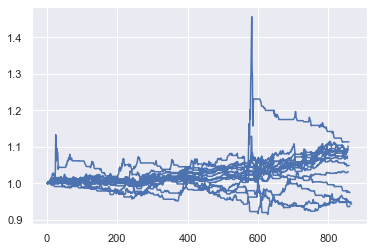

In [24]:
signal_df_all['equity_curve'].plot()

<AxesSubplot:>

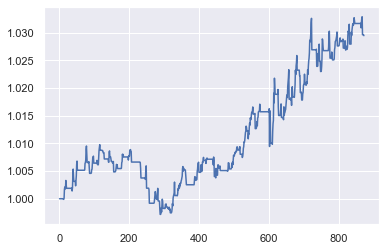

In [49]:
signal_df_all[signal_df_all['Ticker']=='NQ=F']['equity_curve'].plot()

<AxesSubplot:>

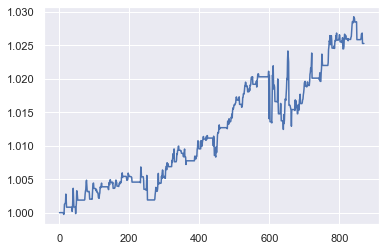

In [50]:
signal_df_all[signal_df_all['Ticker']=='ES=F']['equity_curve'].plot()

In [14]:
signal_list_all[signal_df_all['Ticker']=='YM=F']['equity_curve'].plot()

NameError: name 'signal_list_all' is not defined

In [24]:
# CN_mutual_funds_df = pd.DataFrame()
# CN_mutual_funds_df['Ticker'] = list(CN_mutual_funds_dict.keys())
# CN_mutual_funds_df['CN_Name'] = list(CN_mutual_funds_dict.values())
# signal_df_all = signal_df_all.merge(CN_mutual_funds_df, on = "Ticker")
# CN_mutual_funds_dict

In [26]:
# signal_df_all['CN_Name'].unique()

In [48]:
signal_df_all[signal_df_all['datetime']=='2021-03-24']

,datetime,signal,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL
872,2021-03-24,持仓中,156603.0,1.387547e+06,274,1.544150e+06,-0.000146,1.029434,0.003415,NQ=F,-225.0
870,2021-03-24,无仓位,0.0,1.537936e+06,264,1.537936e+06,0.000000,1.025291,0.003994,ES=F,0.0
867,2021-03-24,无仓位,0.0,1.531967e+06,252,1.531967e+06,0.000000,1.021311,0.000648,YM=F,0.0
872,2021-03-24,清仓,0.0,1.487419e+06,280,1.487419e+06,-0.000001,0.991613,0.018107,GC=F,-2.0
873,2021-03-24,无仓位,0.0,1.487419e+06,280,1.487419e+06,-0.000001,0.991613,0.018107,GC=F,-2.0
873,2021-03-24,无仓位,0.0,1.535028e+06,276,1.535028e+06,0.000000,1.023352,0.008455,CL=F,0.0
882,2021-03-24,无仓位,0.0,1.486405e+06,312,1.486405e+06,0.000000,0.990937,0.010659,XAU=F,0.0
863,2021-03-24,无仓位,0.0,1.633015e+06,236,1.633015e+06,0.000000,1.088676,0.003336,RB=F,0.0
875,2021-03-24,无仓位,0.0,1.518157e+06,284,1.518157e+06,0.000000,1.012105,0.009041,CT=F,0.0
840,2021-03-24,清仓,0.0,1.508247e+06,152,1.508247e+06,-0.000001,1.005498,0.005786,ALI=F,-2.0


In [34]:
perf_df = pd.DataFrame(ticker_performances).T
perf_df.sort_values("overall_score", ascending=False, inplace = True)

perf_df.reset_index(inplace = True)
perf_df.columns = ['Ticker', 'total_commission', 'gross_profit', 'net_profit',
       'commission_impact', 'win %', 'PL Ratio', 'overall_score', 'strat_name',
       'commission', 'backtest_memo']
# perf_df = perf_df.merge(CN_mutual_funds_df, on = "Ticker")

KeyError: 'Ticker'

In [35]:
perf_df

,Ticker,total_commission,gross_profit,net_profit,commission_impact,win %,PL Ratio,overall_score,strat_name,commission,backtest_memo
0,ES=F,3.51,US_ALL,2,0.02%,1.31012e+06,1.30986e+06,2.55,MACD,264,78.79


In [29]:
to_csv_folder = "C:/Users/Administrator/CE_github_2/data_pipeline/Performance/"
perf_df.to_csv(to_csv_folder+"CN_mutual_funds_MACD_UPDOWN_MA_SLOPE_W_COMM.csv")

In [53]:
df_equity_copy

,datetime,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL
0,2018-01-01,0.0,1.500000e+06,0,1.500000e+06,NaN,NaN,NaN,161005,NaN
1,2019-01-02,0.0,1.500000e+06,0,1.500000e+06,0.0,1.00000,0.000000,161005,0.0
2,2019-01-03,0.0,1.500000e+06,0,1.500000e+06,0.0,1.00000,0.000000,161005,0.0
3,2019-01-04,0.0,1.500000e+06,0,1.500000e+06,0.0,1.00000,0.000000,161005,0.0
4,2019-01-07,0.0,1.500000e+06,0,1.500000e+06,0.0,1.00000,0.000000,161005,0.0
...,...,...,...,...,...,...,...,...,...,...
528,2021-03-05,0.0,1.539314e+06,188,1.539314e+06,0.0,1.02621,0.003027,161005,0.0
529,2021-03-08,0.0,1.539314e+06,188,1.539314e+06,0.0,1.02621,0.003027,161005,0.0
530,2021-03-09,0.0,1.539314e+06,188,1.539314e+06,0.0,1.02621,0.003027,161005,0.0
531,2021-03-10,0.0,1.539314e+06,188,1.539314e+06,0.0,1.02621,0.003027,161005,0.0


In [60]:
df_list_data[df_list_data['Ticker']=="001508"]

,market_value,cash,commission,total,returns,equity_curve,drawdown,Ticker,daily_PL
datetime,,,,,,,,,
2018-01-01,0.0,1500000.000,0,1500000.000,NaN,NaN,NaN,001508,NaN
2019-01-02,0.0,1500000.000,0,1500000.000,0.0,1.000000,0.000000,001508,0.0
2019-01-03,0.0,1500000.000,0,1500000.000,0.0,1.000000,0.000000,001508,0.0
2019-01-04,0.0,1500000.000,0,1500000.000,0.0,1.000000,0.000000,001508,0.0
2019-01-07,0.0,1500000.000,0,1500000.000,0.0,1.000000,0.000000,001508,0.0
...,...,...,...,...,...,...,...,...,...
2021-03-05,0.0,1578695.053,168,1578695.053,0.0,1.052463,0.002035,001508,0.0
2021-03-08,0.0,1578695.053,168,1578695.053,0.0,1.052463,0.002035,001508,0.0
2021-03-09,0.0,1578695.053,168,1578695.053,0.0,1.052463,0.002035,001508,0.0


<AxesSubplot:xlabel='datetime'>

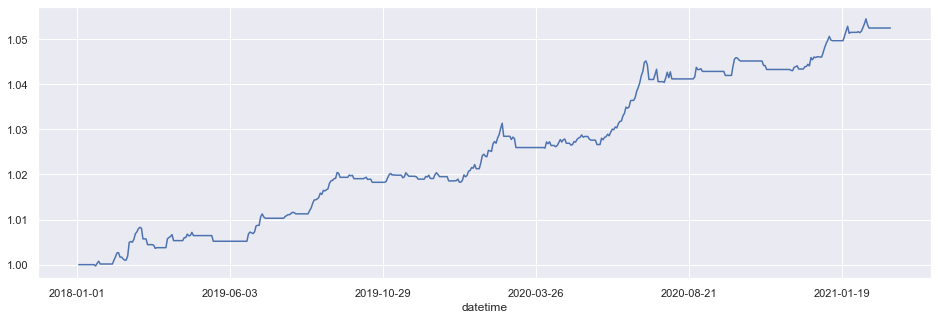

In [61]:
ticker_to_check = "001508"
df_to_check_curve = df_list_data[df_list_data['Ticker']==ticker_to_check]

<AxesSubplot:xlabel='datetime'>

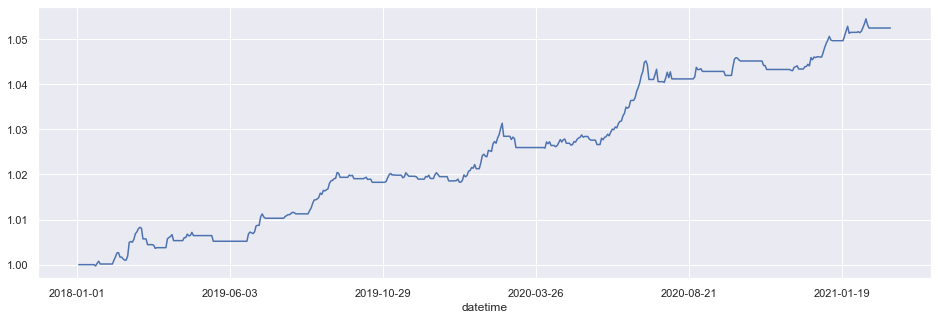

In [62]:
df_to_check_curve['equity_curve'].plot(figsize = (16,5))

In [65]:
data = pd.concat(LOAD_DATA.read_data_from_Sina(['001508'], "2018-01-01", "2021-03-12"))

Loading from SinaFinance: No.1 / 1: 001508
All Data Loaded


In [67]:
data.set_index("Date", inplace = True)

<AxesSubplot:xlabel='Date'>

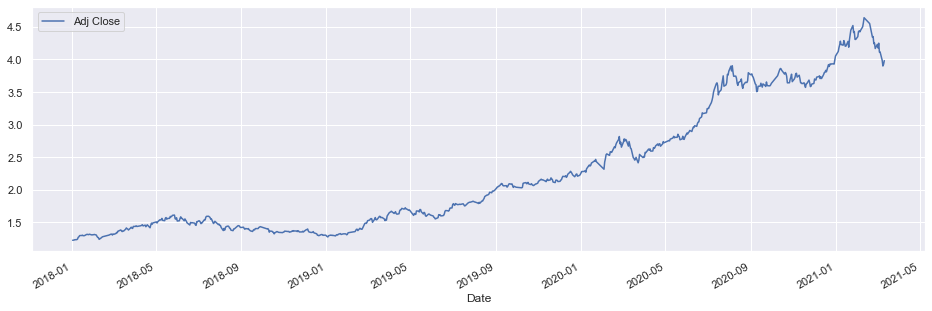

In [69]:
data[['Adj Close']].plot(figsize = (16,5))

# 可视化验证信号

In [6]:
def MACD(df, price_col, n_fast, n_slow, n_ema): # n_fast = 12, n_slow = 26
    """
    http://stockcharts.com/docs/doku.php?id=scans:indicators
    MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
    # Conventional look-back window for calculating MACDsign is 9
    """
    EMAfast = df[price_col].ewm(span = n_fast, min_periods = n_fast - 1).mean()
    EMAslow = df[price_col].ewm(span = n_slow, min_periods = n_slow - 1).mean()
    diff = pd.Series(EMAfast - EMAslow)
    dea = diff.ewm(span = n_ema, min_periods = n_ema-1).mean()
    macd = (pd.Series(diff - dea))*2
    df["DIFF"] = diff
    df["DEA"] = dea
    df["MACD"] = macd
    return df

In [7]:
data = LOAD_DATA.read_data_from_Sina(['003096'], "2018-01-01", "2021-03-26")

Loading from SinaFinance: No.1 / 1: 003096
All Data Loaded


In [11]:
price_col = "Adj Close"
df = pd.concat(data)
df_macd = MACD(df, price_col, 12, 26, 9)

df_macd['MA5'] = pd.Series(df_macd[price_col]).rolling(window=5).mean()
df_macd['MA10'] = pd.Series(df_macd[price_col]).rolling(window=10).mean()

<AxesSubplot:xlabel='Date'>

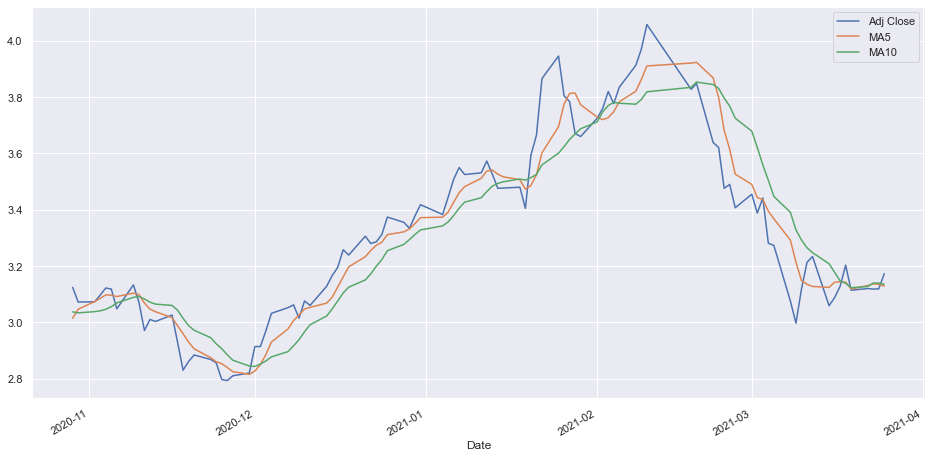

In [12]:
df_macd.set_index("Date", inplace = True)
df_macd[[ 'Adj Close', 'MA5', 'MA10']].tail(100).plot(figsize = (16, 8))

In [13]:
df_macd

,Open,High,Low,Close,Adj Close,Volume,Ticker,DIFF,DEA,MACD,MA5,MA10
Date,,,,,,,,,,,,
2018-01-02,1.229,1.229,1.229,1.229,1.229,1.229,003096,NaN,NaN,NaN,NaN,NaN
2018-01-03,1.234,1.234,1.234,1.234,1.234,1.234,003096,NaN,NaN,NaN,NaN,NaN
2018-01-04,1.246,1.246,1.246,1.246,1.246,1.246,003096,NaN,NaN,NaN,NaN,NaN
2018-01-05,1.245,1.245,1.245,1.245,1.245,1.245,003096,NaN,NaN,NaN,NaN,NaN
2018-01-08,1.247,1.247,1.247,1.247,1.247,1.247,003096,NaN,NaN,NaN,1.2402,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-19,3.114,3.114,3.114,3.114,3.114,3.114,003096,-0.130477,-0.122614,-0.015727,3.1184,3.1229
2021-03-22,3.120,3.120,3.120,3.120,3.120,3.120,003096,-0.126972,-0.123485,-0.006974,3.1306,3.1274
2021-03-23,3.118,3.118,3.118,3.118,3.118,3.118,003096,-0.122939,-0.123376,0.000875,3.1366,3.1395
